In [1]:
# pip install qiskit==0.31.0

In [2]:
from get_test_datasets import return_dataset
test_dataset = return_dataset()

/home/ritu/anaconda3/envs/dnn_for_qubit_mapping/lib/python3.8/site-packages/qiskit/version.py:20: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


Generating QPE circuits


In [3]:
len(test_dataset)

400

In [4]:
import tensorflow as tf
from tensorflow import keras

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from helper import *

Using TensorFlow backend.
ibmqfactory.load_account:WARNING:2023-11-27 11:00:18,393: Credentials are already in use. The existing account in the session will be replaced.


{'ibm_lagos': [[0, 1], [1, 0], [1, 2], [1, 3], [2, 1], [3, 1], [3, 5], [4, 5], [5, 3], [5, 4], [5, 6], [6, 5]], 'ibm_nairobi': [[0, 1], [1, 0], [1, 2], [1, 3], [2, 1], [3, 1], [3, 5], [4, 5], [5, 3], [5, 4], [5, 6], [6, 5]], 'ibm_perth': [[0, 1], [1, 0], [1, 2], [1, 3], [2, 1], [3, 1], [3, 5], [4, 5], [5, 3], [5, 4], [5, 6], [6, 5]]}


In [5]:
mlp_edge_feature = tf.keras.models.load_model("models/mlp_edge_features.keras")
dnn = tf.keras.models.load_model("models/dnn.keras")
mlp = tf.keras.models.load_model("models/mlp.keras")

2023-11-27 11:00:21.664828: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-11-27 11:00:21.710942: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-27 11:00:21.711287: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 4090 computeCapability: 8.9
coreClock: 2.595GHz coreCount: 128 deviceMemorySize: 23.64GiB deviceMemoryBandwidth: 938.86GiB/s
2023-11-27 11:00:21.711621: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2023-11-27 11:00:21.711752: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic lib

In [6]:
basis_gate_dict = {}
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends(simulator=False)
backends = ['ibm_lagos','ibm_perth','ibm_nairobi']
for backend_name in backends:
    backend = provider.get_backend(backend_name)
    basis_gats = backend.configuration().basis_gates
    basis_gate_dict[backend_name] = basis_gats


In [7]:
def get_transpiled_circ_results(qc, backend, initial_layout):
    basis_gats = basis_gate_dict[backend]
    pass_ = Unroller(basis_gats)
    pm = PassManager(pass_)
    backend = provider.get_backend(backend)
    
    tqc = transpile(qc, backend=backend,initial_layout=initial_layout, optimization_level=0,seed_transpiler=13)
    tqc = pm.run(tqc)
    gates = dict(tqc.count_ops())
    return gates['cx'], tqc.depth()


In [46]:
SS = StandardScaler()
num_qubits = 7
count_or = 0
count_nr = 0
count_mlp = 0
count_mlp_edge = 0
original_depth, original_CNOT = [],[]
mlp_edge_depth, mlp_edge_CNOT = [],[]
dnn_without_ro_depth,dnn_without_ro_CNOT = [],[] 
dnn_with_ro_depth,dnn_with_ro_CNOT = [],[] 
mlp_depth, mlp_CNOT = [],[]

dnn_time = []
mlp_time = []
mlp_edge_time = []
sabre_time,na_time,dense_time = [],[],[]
for qc_i in tqdm(range(len(test_dataset[-5:]))):
    qc = test_dataset[qc_i]
    data = datetime.today() - timedelta(days=random.randint(1,150))
    backends = ['ibm_lagos','ibm_perth','ibm_nairobi']
    backend = backends[np.random.randint(0,3)]
    l = add_line(qc,backend, optimization_level=3, refresh=True, show= False, datatime=data)
    
    d={}
    for i in range(len(l[0])):
        d[str(l[0][i])] = l[1][i]
    df = pd.DataFrame(d, index=[0])
    df = clear_dataset(df, 7)
    last_num_qubits = len(df.columns)-num_qubits
    labels = ((df.iloc[:, last_num_qubits:].values)[0]).tolist()
    
#     time_taken_to_get_df = get_df_time(qc,backend,data)
#     print("Preprocess time:",time_taken_to_get_df)
    time_taken_to_get_df = 0
    
    start = time.time()
    x = SS.fit_transform(df.iloc[:, 2:last_num_qubits].values)
    predicted = dnn.predict(x)
    pred_or = np.array(pred_layout(predicted, num_qubits))[0].tolist()
    pred_nr = np.array(pred_layout_diff_elem(predicted,num_qubits))[0].tolist()
    end = time.time()
    dnn_time.append(time_taken_to_get_df + (end-start))
    
    print(pred_or, pred_nr, labels)
    if(pred_or == labels):
        count_or = count_or + 1
    if(pred_nr == labels):
        count_nr = count_nr + 1
    
    start = time.time()
    mlp_pred = get_labels(np.reshape(mlp.predict(x),(7,7)))
    end = time.time()
    mlp_time.append(time_taken_to_get_df + (end-start))
    print(mlp_pred)
    if mlp_pred == labels:
        count_mlp = count_mlp + 1
        
    start = time.time()
    x = SS.fit_transform(get_graph_features(df))
    mlp_edges_pred = get_labels(np.reshape(mlp_edge_feature.predict(x),(7,7)))
    end = time.time()
    mlp_edge_time.append(time_taken_to_get_df + (end-start))
    print(mlp_edges_pred)
    if mlp_edges_pred == labels:
        count_mlp_edge = count_mlp_edge + 1
    
    
    # original circuit after unrolling
    cx, depth = get_transpiled_circ_results(qc, backend, initial_layout=labels)
    original_depth.append(depth)
    original_CNOT.append(cx)
    print(original_depth[-1],original_CNOT[-1])
    # NN with edge features
    if len(mlp_edges_pred) == len(set(mlp_edges_pred)):
        cx, depth = get_transpiled_circ_results(qc, backend, initial_layout=mlp_edges_pred)
        mlp_edge_depth.append(depth)
        mlp_edge_CNOT.append(cx)
    else:
        mlp_edge_depth.append(float('NaN'))
        mlp_edge_CNOT.append(float('NaN'))
        
    # NN without edge features
    if len(mlp_pred) == len(set(mlp_pred)):
        cx, depth = get_transpiled_circ_results(qc, backend, initial_layout=mlp_pred)
        mlp_depth.append(depth)
        mlp_CNOT.append(cx)
    else:
        mlp_depth.append(float('NaN'))
        mlp_CNOT.append(float('NaN'))
        
    # DNN without repair operator
    if len(pred_or) == len(set(pred_or)):
        cx, depth = get_transpiled_circ_results(qc, backend, initial_layout=pred_or)
        dnn_without_ro_depth.append(depth)
        dnn_without_ro_CNOT.append(cx)
    else:
        dnn_without_ro_depth.append(float("NaN"))
        dnn_without_ro_CNOT.append(float("NaN"))
        
    # DNN with RO
    cx, depth = get_transpiled_circ_results(qc, backend, initial_layout=pred_nr)
    dnn_with_ro_depth.append(depth)
    dnn_with_ro_CNOT.append(cx)
    
#     # execution times
    basis_gats = basis_gate_dict[backend]
    pass_ = Unroller(basis_gats)
    pm = PassManager(pass_)
    backend = provider.get_backend(backend)
    tqc = transpile(qc, backend=backend, optimization_level=0)
    tqc = pm.run(tqc)
    # noise adaptive time
    start = time.time()
    new_circ_lv3_na = transpile(tqc, backend=backend, optimization_level=0,layout_method='noise_adaptive')
    new_circ_lv3_na._layout.get_physical_bits()
    end = time.time()
    na_time.append(end-start)
    #  sabre time
    start = time.time()
    new_circ_lv3_sabre = transpile(tqc, backend=backend, optimization_level=0,layout_method='sabre',routing_method='sabre')
    new_circ_lv3_sabre._layout.get_physical_bits()
    end = time.time()
    sabre_time.append(end-start)
    # dense time
    start = time.time()
    new_circ_lv3_dense = transpile(tqc, backend=backend, optimization_level=0)
    new_circ_lv3_dense._layout.get_physical_bits()
    end = time.time()
    dense_time.append(end-start)
    

print("DNN accuracy without repair operator:", count_or/len(test_dataset))
print("DNN accuracy with repair operator:", count_nr/len(test_dataset))
print("MLP accuracy:", count_mlp/len(test_dataset))
print("MLP with edge features accuracy:", count_mlp_edge/len(test_dataset))

  0%|                                                                                                                                                            | 0/5 [00:00<?, ?it/s]

2023-10-09 12:15:08.683877
Backend topology: 2023-10-09 12:15:08.683877
Depth: [92, 92, 78, 78, 78, 78]
not na


,last_update_date,backend_name,N_qubtis,N_cx,cx_01,cx_02,cx_03,cx_04,cx_05,cx_06,...,T1_6,T2_6,readout_error_6,0,1,2,3,4,5,6
0,2023-10-09 11:39:03-07:00,ibm_perth,7,35,8,0,0,0,0,0,...,137.417059,216.542708,0.0112,0,1,2,3,4,5,6


[2, 1, 0, 3, 4, 5, 6] [2, 1, 0, 3, 4, 5, 6] [0, 1, 2, 3, 4, 5, 6]
[6, 1, 4, 3, 4, 5, 6]



 20%|█████████████████████████████▌                                                                                                                      | 1/5 [00:02<00:11,  2.99s/it]

[2, 1, 0, 3, 4, 5, 6]
60 32
2023-07-07 12:15:11.675377
Backend topology: 2023-07-07 12:15:11.675377
Depth: [182, 182, 90, 90, 94, 94]
not na


,last_update_date,backend_name,N_qubtis,N_cx,cx_01,cx_02,cx_03,cx_04,cx_05,cx_06,...,T1_6,T2_6,readout_error_6,0,1,2,3,4,5,6
0,2023-07-07 10:42:22-07:00,ibm_lagos,7,44,0,0,0,0,0,0,...,181.749233,116.403708,0.0159,0,1,2,3,4,5,6


[2, 1, 0, 3, 4, 5, 6] [2, 1, 0, 3, 4, 5, 6] [0, 1, 2, 3, 4, 5, 6]
[6, 1, 4, 3, 4, 5, 6]



 40%|███████████████████████████████████████████████████████████▏                                                                                        | 2/5 [00:07<00:11,  3.68s/it]

[2, 1, 0, 3, 4, 5, 6]
59 44
2023-08-27 12:15:15.839788
Backend topology: 2023-08-27 12:15:15.839788
Depth: [124, 124, 82, 82, 82, 82]
not na


,last_update_date,backend_name,N_qubtis,N_cx,cx_01,cx_02,cx_03,cx_04,cx_05,cx_06,...,T1_6,T2_6,readout_error_6,0,1,2,3,4,5,6
0,2023-08-27 12:10:31-07:00,ibm_perth,7,38,0,0,0,0,0,0,...,97.780636,288.278561,0.0097,0,1,2,3,4,5,6


[2, 1, 0, 3, 4, 5, 6] [2, 1, 0, 3, 4, 5, 6] [0, 1, 2, 3, 4, 5, 6]
[6, 1, 4, 3, 4, 5, 6]



 60%|████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 3/5 [00:15<00:11,  5.66s/it]

[2, 1, 0, 3, 4, 5, 6]
57 38
2023-11-03 12:15:23.854522
Backend topology: 2023-11-03 12:15:23.854522
Depth: [120, 120, 76, 76, 80, 80]
not na


,last_update_date,backend_name,N_qubtis,N_cx,cx_01,cx_02,cx_03,cx_04,cx_05,cx_06,...,T1_6,T2_6,readout_error_6,0,1,2,3,4,5,6
0,2023-11-03 10:10:06-07:00,ibm_perth,7,35,0,0,0,0,0,0,...,188.137705,259.427085,0.0131,0,1,2,3,4,5,6


[2, 1, 0, 3, 4, 5, 6] [2, 1, 0, 3, 4, 5, 6] [0, 1, 2, 3, 4, 5, 6]
[6, 1, 4, 3, 4, 5, 6]



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 4/5 [00:16<00:04,  4.13s/it]

[2, 1, 0, 3, 4, 5, 6]
56 29
2023-09-12 12:15:25.646809
Backend topology: 2023-09-12 12:15:25.646809
Depth: [110, 110, 80, 80, 80, 80]
not na


,last_update_date,backend_name,N_qubtis,N_cx,cx_01,cx_02,cx_03,cx_04,cx_05,cx_06,...,T1_6,T2_6,readout_error_6,0,1,2,3,4,5,6
0,2023-09-12 11:00:34-07:00,ibm_perth,7,32,4,0,0,0,0,0,...,248.836281,213.623966,0.0129,0,1,2,3,4,5,6


[2, 1, 0, 3, 4, 5, 6] [2, 1, 0, 3, 4, 5, 6] [0, 1, 2, 3, 4, 5, 6]
[6, 1, 4, 3, 4, 5, 6]



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:18<00:00,  3.76s/it]

[2, 1, 0, 3, 4, 5, 6]
60 32
DNN accuracy without repair operator: 0.0
DNN accuracy with repair operator: 0.0
MLP accuracy: 0.0
MLP with edge features accuracy: 0.0


In [20]:
df = pd.DataFrame()
df["Label Depth"] = original_depth
df["Label CNOTs"] = original_CNOT

df["NN without edge features Depth"] = mlp_depth
df["NN without edge features CNOTs"] = mlp_CNOT

df["NN with edge features Depth"] = mlp_edge_depth
df["NN with edge features CNOTs"] = mlp_edge_CNOT

df["DNN without repair Depth"] = dnn_without_ro_depth
df["DNN without repair CNOTs"] = dnn_without_ro_CNOT

df["DNN with repair Depth"] = dnn_with_ro_depth
df["DNN with repair CNOTs"] = dnn_with_ro_CNOT

df["DNN Mapping time"] = dnn_time
df["NN without edge features Mapping time"] = mlp_time
df["NN with edge features Mapping time"] = mlp_edge_time
df["SABRE mapping Mapping time"] = sabre_time
df["Noise Adaptive Mapping time"] = na_time
df["Dense Mapping time"] = dense_time

In [21]:
df

,Label Depth,Label CNOTs,NN without edge features Depth,NN without edge features CNOTs,NN with edge features Depth,NN with edge features CNOTs,DNN without repair Depth,DNN without repair CNOTs,DNN with repair Depth,DNN with repair CNOTs,DNN Mapping time,NN without edge features Mapping time,NN with edge features Mapping time,SABRE mapping Mapping time,Noise Adaptive Mapping time,Dense Mapping time
0,60,32,NaN,NaN,62,35,62,35,62,35,0.010940,0.008420,0.013839,0.011827,0.011510,0.002655
1,59,44,NaN,NaN,59,44,59,44,59,44,0.010616,0.008597,0.012853,0.014319,0.014587,0.002804
2,57,38,NaN,NaN,57,38,57,38,57,38,0.011061,0.008651,0.012619,0.009130,0.015255,0.002752
3,66,44,NaN,NaN,56,29,56,29,56,29,0.010974,0.008689,0.013744,0.012737,0.011660,0.002606
4,56,29,NaN,NaN,62,35,62,35,62,35,0.010890,0.008564,0.013134,0.008358,0.002935,0.002746


In [ ]:
import itertools
layouts = list(itertools.permutations([0,1,2,3,4,5,6]))
qc = test_dataset[-8]
basis_gats = basis_gate_dict['ibm_nairobi']
pass_ = Unroller(basis_gats)
pm = PassManager(pass_)
backend = provider.get_backend('ibm_nairobi')
for l in layouts[:20]:
    tqc = transpile(qc, backend=backend,initial_layout=list(l), optimization_level=0)
    tqc = pm.run(tqc)
    
    print(l,tqc.depth(),dict(tqc.count_ops())['cx'])

## Depth vs. Mapping time

In [75]:
from qiskit.circuit.random import random_circuit


In [93]:
dnn_time = []
mlp_time = []
mlp_edge_time = []
sabre_time,na_time,dense_time = [],[],[]
for depth in tqdm(range(1,51)):#51)):
#     num_qubits = np.random.randint(5,8)
    
    curr_dnn_time,curr_mlp_time,curr_mlp_edge_time,curr_sabre_time,curr_na_time,curr_dense_time=0,0,0,0,0,0
    print("Current depth:",depth)
    itrs=10
    for _ in range(itrs):
        qc = random_circuit(7, depth, measure=True)  
        data = datetime.today() - timedelta(days=random.randint(1,150))
        backends = ['ibm_lagos','ibm_perth','ibm_nairobi']
        backend = backends[np.random.randint(0,3)]
        l = add_line(qc,backend, optimization_level=3, refresh=True, show= False, datatime=data)

        d={}
        for i in range(len(l[0])):
            d[str(l[0][i])] = l[1][i]
        df = pd.DataFrame(d, index=[0])
        df = clear_dataset(df, 7)
        last_num_qubits = len(df.columns)-num_qubits
        labels = ((df.iloc[:, last_num_qubits:].values)[0]).tolist()

    #     time_taken_to_get_df = get_df_time(qc,backend,data)
    #     print("Preprocess time:",time_taken_to_get_df)
        time_taken_to_get_df = 0

        start = time.time()

        x = SS.fit_transform(df.iloc[:, 2:last_num_qubits].values)
        predicted = dnn.predict(x)
        pred_or = np.array(pred_layout(predicted, num_qubits))[0].tolist()
        pred_nr = np.array(pred_layout_diff_elem(predicted,num_qubits))[0].tolist()
        end = time.time()
        curr_dnn_time=curr_dnn_time+(time_taken_to_get_df + (end-start))


        start = time.time()
        mlp_pred = get_labels(np.reshape(mlp.predict(x),(7,7)))
        end = time.time()
        curr_mlp_time=curr_mlp_time + (time_taken_to_get_df + (end-start))


        start = time.time()
        x = SS.fit_transform(get_graph_features(df))
        mlp_edges_pred = get_labels(np.reshape(mlp_edge_feature.predict(x),(7,7)))
        end = time.time()
        curr_mlp_edge_time=curr_mlp_edge_time+(time_taken_to_get_df + (end-start))

    #     # execution times
        basis_gats = basis_gate_dict[backend]
        pass_ = Unroller(basis_gats)
        pm = PassManager(pass_)
        backend = provider.get_backend(backend)
        tqc = transpile(qc, backend=backend, optimization_level=0)
        tqc = pm.run(tqc)
        # noise adaptive time
        start = time.time()
        new_circ_lv3_na = transpile(tqc, backend=backend, optimization_level=0,layout_method='noise_adaptive')
        new_circ_lv3_na._layout.get_physical_bits()
        end = time.time()
        curr_na_time=curr_na_time+(end-start)
        # sabre time
        start = time.time()
        new_circ_lv3_sabre = transpile(tqc, backend=backend, optimization_level=0,layout_method='sabre',routing_method='sabre')
        new_circ_lv3_sabre._layout.get_physical_bits()
        end = time.time()
        curr_sabre_time=curr_sabre_time+(end-start)
        # dense time
        start = time.time()
        new_circ_lv3_dense = transpile(tqc, backend=backend, optimization_level=0)
        new_circ_lv3_dense._layout.get_physical_bits()
        end = time.time()
        curr_dense_time=curr_dense_time+(end-start)
    dnn_time.append(curr_dnn_time/itrs)
    mlp_time.append(curr_mlp_time/itrs)
    mlp_edge_time.append(curr_mlp_edge_time/itrs)
    sabre_time.append(curr_sabre_time/itrs)
    dense_time.append(curr_dense_time/itrs)
    na_time.append(curr_na_time/itrs)
    

    

  0%|                                                                                                                                                           | 0/50 [00:00<?, ?it/s]

Current depth: 1
2023-06-30 19:14:14.180618
Backend topology: 2023-06-30 19:14:14.180618
Depth: [92, 92, 76, 76, 76, 76]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 518.46it/s]


2023-08-27 19:14:16.131597
Backend topology: 2023-08-27 19:14:16.131597
Depth: [16, 16, 16, 16, 28, 28]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 264.04it/s]


2023-08-09 19:14:17.800440
Backend topology: 2023-08-09 19:14:17.800440
Depth: [230, 230, 136, 136, 138, 138]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 546.49it/s]


2023-10-09 19:14:20.088568
Backend topology: 2023-10-09 19:14:20.088568
Depth: [122, 122, 72, 72, 110, 110]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 536.49it/s]


2023-09-19 19:14:22.027179
Backend topology: 2023-09-19 19:14:22.027179
Depth: [74, 74, 64, 64, 68, 68]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 558.42it/s]


2023-10-07 19:14:23.789865
Backend topology: 2023-10-07 19:14:23.789865
Depth: [118, 118, 118, 118, 116, 116]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 518.01it/s]


2023-07-08 19:14:25.694251
Backend topology: 2023-07-08 19:14:25.694251
Depth: [26, 26, 32, 32, 38, 38]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 512.50it/s]


2023-08-28 19:14:27.278285
Backend topology: 2023-08-28 19:14:27.278285
Depth: [94, 94, 50, 50, 70, 70]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 529.58it/s]


2023-10-30 19:14:29.078357
Backend topology: 2023-10-30 19:14:29.078357
Depth: [58, 58, 58, 58, 70, 70]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 530.12it/s]


2023-07-26 19:14:31.134773
Backend topology: 2023-07-26 19:14:31.134773
Depth: [54, 54, 20, 20, 20, 20]
not na



  2%|██▉                                                                                                                                                | 1/50 [00:22<18:36, 22.78s/it]

Current depth: 2
2023-07-18 19:14:36.965704
Backend topology: 2023-07-18 19:14:36.965704
Depth: [80, 80, 80, 80, 80, 80]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 534.31it/s]


2023-09-16 19:14:53.800568
Backend topology: 2023-09-16 19:14:53.800568
Depth: [376, 376, 128, 128, 128, 128]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 538.15it/s]


2023-11-10 19:14:55.923989
Backend topology: 2023-11-10 19:14:55.923989
Depth: [398, 398, 162, 162, 162, 162]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 317.49it/s]


2023-10-05 19:14:58.462039
Backend topology: 2023-10-05 19:14:58.462039
Depth: [150, 150, 150, 150, 148, 148]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 382.31it/s]


2023-10-21 19:15:00.584356
Backend topology: 2023-10-21 19:15:00.584356
Depth: [126, 126, 126, 126, 172, 172]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 535.53it/s]


2023-08-12 19:15:02.894499
Backend topology: 2023-08-12 19:15:02.894499
Depth: [126, 126, 126, 126, 126, 126]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 506.07it/s]


2023-08-07 19:15:05.111238
Backend topology: 2023-08-07 19:15:05.111238
Depth: [100, 100, 100, 100, 116, 116]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 340.75it/s]


2023-11-22 19:15:07.234501
Backend topology: 2023-11-22 19:15:07.234501
Depth: [142, 142, 138, 138, 138, 138]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 383.57it/s]


2023-08-24 19:15:09.538035
Backend topology: 2023-08-24 19:15:09.538035
Depth: [148, 148, 148, 148, 202, 202]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 502.31it/s]


2023-09-17 19:15:14.131855
Backend topology: 2023-09-17 19:15:14.131855
Depth: [240, 240, 102, 102, 102, 102]
not na



  4%|█████▉                                                                                                                                             | 2/50 [01:02<26:06, 32.63s/it]

Current depth: 3
2023-07-06 19:15:16.485372
Backend topology: 2023-07-06 19:15:16.485372
Depth: [236, 236, 234, 234, 234, 234]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 533.22it/s]


2023-11-11 19:15:18.858718
Backend topology: 2023-11-11 19:15:18.858718
Depth: [92, 92, 86, 86, 120, 120]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 540.78it/s]


2023-10-19 19:15:20.986630
Backend topology: 2023-10-19 19:15:20.986630
Depth: [176, 176, 156, 156, 154, 154]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 527.85it/s]


2023-11-06 19:15:23.130762
Backend topology: 2023-11-06 19:15:23.130762
Depth: [538, 538, 266, 266, 266, 266]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 531.46it/s]


2023-11-04 19:15:25.929587
Backend topology: 2023-11-04 19:15:25.929587
Depth: [166, 166, 168, 168, 168, 168]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.08it/s]


2023-10-04 19:15:28.232805
Backend topology: 2023-10-04 19:15:28.232805
Depth: [148, 148, 148, 148, 148, 148]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 523.31it/s]


2023-11-22 19:15:38.197105
Backend topology: 2023-11-22 19:15:38.197105
Depth: [186, 186, 186, 186, 186, 186]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 571.66it/s]


2023-10-18 19:15:43.260444
Backend topology: 2023-10-18 19:15:43.260444
Depth: [208, 208, 92, 92, 92, 92]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 556.94it/s]


2023-11-03 19:15:45.792256
Backend topology: 2023-11-03 19:15:45.792256
Depth: [146, 146, 146, 146, 204, 204]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 514.95it/s]


2023-10-03 19:16:00.101888
Backend topology: 2023-10-03 19:16:00.101888
Depth: [484, 484, 214, 214, 214, 214]
not na



  6%|████████▊                                                                                                                                          | 3/50 [01:48<30:29, 38.92s/it]

Current depth: 4
2023-08-04 19:16:02.894839
Backend topology: 2023-08-04 19:16:02.894839
Depth: [450, 450, 294, 294, 294, 294]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 535.47it/s]


2023-11-10 19:16:05.849073
Backend topology: 2023-11-10 19:16:05.849073
Depth: [232, 232, 162, 162, 162, 162]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 583.03it/s]


2023-08-25 19:16:07.949009
Backend topology: 2023-08-25 19:16:07.949009
Depth: [552, 552, 288, 288, 288, 288]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 558.35it/s]


2023-11-06 19:16:11.259765
Backend topology: 2023-11-06 19:16:11.259765
Depth: [306, 306, 202, 202, 202, 202]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 545.42it/s]


2023-07-08 19:16:13.603090
Backend topology: 2023-07-08 19:16:13.603090
Depth: [184, 184, 182, 182, 256, 256]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 340.36it/s]


2023-09-16 19:16:15.986842
Backend topology: 2023-09-16 19:16:15.986842
Depth: [230, 230, 232, 232, 232, 232]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 521.74it/s]


2023-11-17 19:16:18.287175
Backend topology: 2023-11-17 19:16:18.287175
Depth: [232, 232, 236, 236, 232, 232]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 350.14it/s]


2023-09-24 19:16:20.754976
Backend topology: 2023-09-24 19:16:20.754976
Depth: [196, 196, 204, 204, 204, 204]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 503.40it/s]


2023-07-07 19:16:23.368715
Backend topology: 2023-07-07 19:16:23.368715
Depth: [254, 254, 192, 192, 192, 192]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 540.99it/s]


2023-09-22 19:16:25.750348
Backend topology: 2023-09-22 19:16:25.750348
Depth: [260, 260, 258, 258, 258, 258]
not na



  8%|███████████▊                                                                                                                                       | 4/50 [02:14<25:47, 33.63s/it]

Current depth: 5
2023-11-11 19:16:28.421694
Backend topology: 2023-11-11 19:16:28.421694
Depth: [308, 308, 298, 298, 298, 298]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 561.49it/s]


2023-11-06 19:16:31.074069
Backend topology: 2023-11-06 19:16:31.074069
Depth: [272, 272, 276, 276, 276, 276]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 382.69it/s]


2023-10-16 19:16:33.640581
Backend topology: 2023-10-16 19:16:33.640581
Depth: [256, 256, 256, 256, 256, 256]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 544.93it/s]


2023-08-11 19:16:36.293885
Backend topology: 2023-08-11 19:16:36.293885
Depth: [148, 148, 148, 148, 148, 148]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 358.79it/s]


2023-09-09 19:16:38.349409
Backend topology: 2023-09-09 19:16:38.349409
Depth: [264, 264, 254, 254, 254, 254]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 496.02it/s]


2023-11-24 19:16:41.175993
Backend topology: 2023-11-24 19:16:41.175993
Depth: [424, 424, 362, 362, 362, 362]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 291.01it/s]


2023-07-03 19:16:44.285210
Backend topology: 2023-07-03 19:16:44.285210
Depth: [374, 374, 368, 368, 368, 368]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 604.89it/s]


2023-10-08 19:16:47.298703
Backend topology: 2023-10-08 19:16:47.298703
Depth: [468, 468, 278, 278, 278, 278]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 580.61it/s]


2023-08-03 19:16:50.550169
Backend topology: 2023-08-03 19:16:50.550169
Depth: [498, 498, 312, 312, 312, 312]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 587.52it/s]


2023-11-13 19:16:53.862984
Backend topology: 2023-11-13 19:16:53.862984
Depth: [468, 468, 302, 302, 302, 302]
not na



 10%|██████████████▋                                                                                                                                    | 5/50 [02:42<23:53, 31.85s/it]

Current depth: 6
2023-07-02 19:16:57.113051
Backend topology: 2023-07-02 19:16:57.113051
Depth: [474, 474, 398, 398, 398, 398]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 345.69it/s]


2023-09-07 19:17:00.178804
Backend topology: 2023-09-07 19:17:00.178804
Depth: [326, 326, 334, 334, 336, 336]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 352.55it/s]


2023-07-22 19:17:03.099713
Backend topology: 2023-07-22 19:17:03.099713
Depth: [792, 792, 354, 354, 354, 354]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 604.98it/s]


2023-09-27 19:17:06.688831
Backend topology: 2023-09-27 19:17:06.688831
Depth: [354, 354, 350, 350, 348, 348]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 543.09it/s]


2023-11-22 19:17:09.654201
Backend topology: 2023-11-22 19:17:09.654201
Depth: [276, 276, 276, 276, 272, 272]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 528.85it/s]


2023-08-23 19:17:12.524787
Backend topology: 2023-08-23 19:17:12.524787
Depth: [262, 262, 258, 258, 260, 260]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 550.22it/s]


2023-10-01 19:17:14.844680
Backend topology: 2023-10-01 19:17:14.844680
Depth: [370, 370, 372, 372, 374, 374]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 562.69it/s]


2023-07-25 19:17:17.729249
Backend topology: 2023-07-25 19:17:17.729249
Depth: [388, 388, 376, 376, 384, 384]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 363.93it/s]


2023-08-27 19:17:21.232974
Backend topology: 2023-08-27 19:17:21.232974
Depth: [720, 720, 362, 362, 362, 362]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 562.84it/s]


2023-11-07 19:17:24.874546
Backend topology: 2023-11-07 19:17:24.874546
Depth: [498, 498, 496, 496, 496, 496]
not na



 12%|█████████████████▋                                                                                                                                 | 6/50 [03:14<23:21, 31.86s/it]

Current depth: 7
2023-07-07 19:17:28.988669
Backend topology: 2023-07-07 19:17:28.988669
Depth: [930, 930, 466, 466, 466, 466]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 560.59it/s]


2023-09-07 19:17:33.184652
Backend topology: 2023-09-07 19:17:33.184652
Depth: [386, 386, 400, 400, 400, 400]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 573.31it/s]


2023-11-05 19:17:36.306010
Backend topology: 2023-11-05 19:17:36.306010
Depth: [460, 460, 354, 354, 354, 354]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 376.34it/s]


2023-10-08 19:17:39.536463
Backend topology: 2023-10-08 19:17:39.536463
Depth: [482, 482, 488, 488, 500, 500]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 528.52it/s]


2023-07-14 19:17:43.249551
Backend topology: 2023-07-14 19:17:43.249551
Depth: [1034, 1034, 556, 556, 556, 556]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 537.18it/s]


2023-10-08 19:17:48.298421
Backend topology: 2023-10-08 19:17:48.298421
Depth: [318, 318, 318, 318, 318, 318]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 584.00it/s]


2023-07-15 19:18:17.726260
Backend topology: 2023-07-15 19:18:17.726260


/home/ritu/anaconda3/envs/dnn_for_qubit_mapping/lib/python3.8/site-packages/qiskit/transpiler/runningpassmanager.py:166: UserWarning: Resynthesized 


and got


but the original was native (for ['id', 'rz', 'sx', 'x', 'cx', 'reset']) and the new value is longer.  This indicates an efficiency bug in synthesis.  Please report it by opening an issue here: https://github.com/Qiskit/qiskit-terra/issues/new/choose
  new_dag = pass_.run(dag)
/home/ritu/anaconda3/envs/dnn_for_qubit_mapping/lib/python3.8/site-packages/qiskit/transpiler/runningpassmanager.py:166: UserWarning: Resynthesized 


and got


but the original was native (for ['id', 'rz', 'sx', 'x', 'cx', 'reset']) and the new value is longer.  This indicates an efficiency bug in synthesis.  Please report it by opening an issue here: https://github.com/Qiskit/qiskit-terra/issues/new/choose
  new_dag = pass_.run(dag)
/home/ritu/anaconda3/envs/dnn_for_qubit_mapping/lib/python3.8/site-packages/qiskit/transpiler/runningpassmanager.py:166: U

Depth: [1054, 1054, 572, 572, 572, 572]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 406.31it/s]


2023-11-23 19:18:23.207169
Backend topology: 2023-11-23 19:18:23.207169
Depth: [412, 412, 322, 322, 322, 322]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 345.32it/s]


2023-10-09 19:18:26.271688
Backend topology: 2023-10-09 19:18:26.271688
Depth: [472, 472, 474, 474, 472, 472]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 264.56it/s]


2023-10-26 19:18:29.884521
Backend topology: 2023-10-26 19:18:29.884521
Depth: [396, 396, 390, 390, 388, 388]
SABRE



 14%|████████████████████▌                                                                                                                              | 7/50 [04:19<30:31, 42.59s/it]

Current depth: 8
2023-11-25 19:18:33.667079
Backend topology: 2023-11-25 19:18:33.667079
Depth: [790, 790, 492, 492, 492, 492]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 556.27it/s]


2023-11-11 19:18:37.668620
Backend topology: 2023-11-11 19:18:37.668620
Depth: [824, 824, 474, 474, 474, 474]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 600.99it/s]


2023-09-05 19:18:41.314590
Backend topology: 2023-09-05 19:18:41.314590
Depth: [978, 978, 534, 534, 528, 528]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 384.69it/s]


2023-10-23 19:18:45.499618
Backend topology: 2023-10-23 19:18:45.499618
Depth: [540, 540, 472, 472, 472, 472]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 531.33it/s]


2023-10-19 19:18:49.294821
Backend topology: 2023-10-19 19:18:49.294821
Depth: [314, 314, 308, 308, 316, 316]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 556.79it/s]


2023-07-25 19:18:52.829809
Backend topology: 2023-07-25 19:18:52.829809
Depth: [528, 528, 364, 364, 364, 364]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 494.55it/s]


2023-07-03 19:18:56.173336
Backend topology: 2023-07-03 19:18:56.173336
Depth: [512, 512, 522, 522, 512, 512]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 527.59it/s]


2023-10-19 19:18:59.869433
Backend topology: 2023-10-19 19:18:59.869433
Depth: [432, 432, 428, 428, 424, 424]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 541.83it/s]


2023-08-30 19:19:03.542173
Backend topology: 2023-08-30 19:19:03.542173
Depth: [530, 530, 516, 516, 516, 516]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 575.67it/s]


2023-09-13 19:19:07.507420
Backend topology: 2023-09-13 19:19:07.507420
Depth: [1190, 1190, 572, 572, 572, 572]
not na



 16%|███████████████████████▌                                                                                                                           | 8/50 [05:07<30:54, 44.16s/it]

Current depth: 9
2023-08-18 19:19:21.202244
Backend topology: 2023-08-18 19:19:21.202244
Depth: [594, 594, 574, 574, 582, 582]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 548.56it/s]


2023-08-03 19:19:25.988509
Backend topology: 2023-08-03 19:19:25.988509
Depth: [694, 694, 688, 688, 688, 688]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 539.67it/s]


2023-07-22 19:19:30.369904
Backend topology: 2023-07-22 19:19:30.369904
Depth: [944, 944, 522, 522, 522, 522]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 547.92it/s]


2023-09-06 19:19:34.648736
Backend topology: 2023-09-06 19:19:34.648736
Depth: [514, 514, 514, 514, 516, 516]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 549.71it/s]


2023-07-07 19:19:38.597909
Backend topology: 2023-07-07 19:19:38.597909
Depth: [552, 552, 546, 546, 552, 552]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 596.97it/s]


2023-11-17 19:19:42.740701
Backend topology: 2023-11-17 19:19:42.740701
Depth: [498, 498, 496, 496, 498, 498]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 385.79it/s]


2023-08-24 19:19:46.234391
Backend topology: 2023-08-24 19:19:46.234391
Depth: [366, 366, 354, 354, 362, 362]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 544.01it/s]


2023-09-11 19:19:49.636195
Backend topology: 2023-09-11 19:19:49.636195
Depth: [1014, 1014, 546, 546, 546, 546]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 519.55it/s]


2023-10-30 19:19:54.015499
Backend topology: 2023-10-30 19:19:54.015499
Depth: [434, 434, 432, 432, 432, 432]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 600.90it/s]


2023-08-01 19:19:57.364887
Backend topology: 2023-08-01 19:19:57.364887
Depth: [754, 754, 586, 586, 600, 600]
not na



 18%|██████████████████████████▍                                                                                                                        | 9/50 [05:47<29:23, 43.00s/it]

Current depth: 10
2023-08-08 19:20:01.648970
Backend topology: 2023-08-08 19:20:01.648970
Depth: [516, 516, 516, 516, 516, 516]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 527.19it/s]


2023-09-16 19:20:05.428293
Backend topology: 2023-09-16 19:20:05.428293
Depth: [664, 664, 664, 664, 662, 662]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 422.39it/s]


2023-08-09 19:20:09.956664
Backend topology: 2023-08-09 19:20:09.956664
Depth: [772, 772, 798, 798, 772, 772]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 553.85it/s]


2023-09-01 19:20:14.634359
Backend topology: 2023-09-01 19:20:14.634359
Depth: [670, 670, 670, 670, 670, 670]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 584.08it/s]


2023-10-18 19:20:19.307184
Backend topology: 2023-10-18 19:20:19.307184
Depth: [582, 582, 580, 580, 584, 584]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 395.32it/s]


2023-09-08 19:20:23.396265
Backend topology: 2023-09-08 19:20:23.396265
Depth: [894, 894, 530, 530, 524, 524]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 622.49it/s]


2023-07-08 19:20:27.596596
Backend topology: 2023-07-08 19:20:27.596596
Depth: [762, 762, 764, 764, 768, 768]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 578.84it/s]


2023-10-28 19:20:32.680119
Backend topology: 2023-10-28 19:20:32.680119
Depth: [640, 640, 642, 642, 640, 640]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 553.27it/s]


2023-10-07 19:20:37.436870
Backend topology: 2023-10-07 19:20:37.436870
Depth: [818, 818, 810, 810, 784, 784]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 576.38it/s]


2023-08-02 19:20:42.366771
Backend topology: 2023-08-02 19:20:42.366771
Depth: [844, 844, 838, 838, 838, 838]
not na



 20%|█████████████████████████████▏                                                                                                                    | 10/50 [06:32<29:10, 43.76s/it]

Current depth: 11
2023-10-24 19:20:47.123415
Backend topology: 2023-10-24 19:20:47.123415
Depth: [724, 724, 724, 724, 722, 722]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 609.81it/s]


2023-09-24 19:20:51.484863
Backend topology: 2023-09-24 19:20:51.484863
Depth: [650, 650, 584, 584, 578, 578]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 587.77it/s]


2023-07-06 19:20:56.407854
Backend topology: 2023-07-06 19:20:56.407854
Depth: [1446, 1446, 720, 720, 720, 720]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 589.09it/s]


2023-11-18 19:21:01.820158
Backend topology: 2023-11-18 19:21:01.820158
Depth: [566, 566, 562, 562, 562, 562]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 559.84it/s]


2023-11-18 19:21:05.832800
Backend topology: 2023-11-18 19:21:05.832800
Depth: [468, 468, 466, 466, 466, 466]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 557.53it/s]


2023-09-15 19:21:09.120150
Backend topology: 2023-09-15 19:21:09.120150
Depth: [708, 708, 718, 718, 718, 718]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 597.31it/s]


2023-10-24 19:21:13.418765
Backend topology: 2023-10-24 19:21:13.418765
Depth: [744, 744, 742, 742, 740, 740]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 603.93it/s]


2023-09-22 19:21:18.074617
Backend topology: 2023-09-22 19:21:18.074617
Depth: [1284, 1284, 734, 734, 734, 734]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 534.44it/s]


2023-11-22 19:21:23.328017
Backend topology: 2023-11-22 19:21:23.328017
Depth: [864, 864, 880, 880, 880, 880]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 554.00it/s]


2023-08-29 19:21:28.571581
Backend topology: 2023-08-29 19:21:28.571581
Depth: [758, 758, 760, 760, 760, 760]
na



 22%|████████████████████████████████                                                                                                                  | 11/50 [07:18<28:51, 44.39s/it]

Current depth: 12
2023-08-11 19:21:32.942690
Backend topology: 2023-08-11 19:21:32.942690
Depth: [1182, 1182, 652, 652, 652, 652]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 402.91it/s]


2023-09-27 19:21:38.492623
Backend topology: 2023-09-27 19:21:38.492623
Depth: [818, 818, 804, 804, 804, 804]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 400.14it/s]


2023-07-05 19:21:43.398739
Backend topology: 2023-07-05 19:21:43.398739
Depth: [648, 648, 646, 646, 650, 650]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 389.12it/s]


2023-08-12 19:21:47.912750
Backend topology: 2023-08-12 19:21:47.912750
Depth: [642, 642, 624, 624, 624, 624]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 620.64it/s]


2023-07-21 19:21:52.320330
Backend topology: 2023-07-21 19:21:52.320330
Depth: [896, 896, 892, 892, 900, 900]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 420.14it/s]


2023-09-11 19:21:58.917634
Backend topology: 2023-09-11 19:21:58.917634
Depth: [1146, 1146, 656, 656, 656, 656]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 578.84it/s]


2023-08-18 19:22:03.897819
Backend topology: 2023-08-18 19:22:03.897819
Depth: [1224, 1224, 654, 654, 654, 654]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 589.50it/s]


2023-11-20 19:22:08.865039
Backend topology: 2023-11-20 19:22:08.865039
Depth: [596, 596, 602, 602, 600, 600]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 572.68it/s]


2023-11-04 19:22:12.935058
Backend topology: 2023-11-04 19:22:12.935058
Depth: [582, 582, 572, 572, 572, 572]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 567.80it/s]


2023-11-06 19:22:17.468125
Backend topology: 2023-11-06 19:22:17.468125
Depth: [1102, 1102, 806, 806, 792, 792]
SABRE



 24%|███████████████████████████████████                                                                                                               | 12/50 [08:08<29:07, 45.99s/it]

Current depth: 13
2023-08-07 19:22:22.571519
Backend topology: 2023-08-07 19:22:22.571519
Depth: [858, 858, 852, 852, 838, 838]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 400.26it/s]


2023-08-12 19:22:27.834979
Backend topology: 2023-08-12 19:22:27.834979
Depth: [902, 902, 806, 806, 804, 804]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 565.65it/s]


2023-08-24 19:22:33.760275
Backend topology: 2023-08-24 19:22:33.760275
Depth: [814, 814, 796, 796, 814, 814]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 557.31it/s]


2023-11-14 19:22:38.609539
Backend topology: 2023-11-14 19:22:38.609539
Depth: [764, 764, 686, 686, 690, 690]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 380.61it/s]


2023-08-06 19:22:43.437222
Backend topology: 2023-08-06 19:22:43.437222
Depth: [1116, 1116, 946, 946, 944, 944]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 533.76it/s]


2023-10-15 19:22:48.695344
Backend topology: 2023-10-15 19:22:48.695344
Depth: [798, 798, 708, 708, 708, 708]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 599.19it/s]


2023-10-29 19:22:54.120008
Backend topology: 2023-10-29 19:22:54.120008
Depth: [934, 934, 928, 928, 928, 928]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 584.57it/s]


2023-10-29 19:22:59.511132
Backend topology: 2023-10-29 19:22:59.511132
Depth: [896, 896, 712, 712, 712, 712]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 544.15it/s]


2023-11-07 19:23:04.562403
Backend topology: 2023-11-07 19:23:04.562403
Depth: [924, 924, 906, 906, 916, 916]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 414.83it/s]


2023-10-10 19:23:10.648996
Backend topology: 2023-10-10 19:23:10.648996
Depth: [626, 626, 620, 620, 620, 620]
not na



 26%|█████████████████████████████████████▉                                                                                                            | 13/50 [09:00<29:28, 47.81s/it]

Current depth: 14
2023-07-06 19:23:14.572318
Backend topology: 2023-07-06 19:23:14.572318
Depth: [744, 744, 736, 736, 742, 742]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 380.30it/s]


2023-11-04 19:23:19.011001
Backend topology: 2023-11-04 19:23:19.011001
Depth: [848, 848, 848, 848, 848, 848]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 585.14it/s]


2023-10-31 19:23:24.734584
Backend topology: 2023-10-31 19:23:24.734584
Depth: [1118, 1118, 822, 822, 822, 822]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 579.64it/s]


2023-11-17 19:23:30.805159
Backend topology: 2023-11-17 19:23:30.805159
Depth: [780, 780, 786, 786, 790, 790]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 599.61it/s]


2023-09-11 19:23:36.545686
Backend topology: 2023-09-11 19:23:36.545686
Depth: [1028, 1028, 1028, 1028, 1028, 1028]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 408.48it/s]


2023-11-20 19:23:42.695398
Backend topology: 2023-11-20 19:23:42.695398
Depth: [834, 834, 704, 704, 704, 704]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 530.32it/s]


2023-09-30 19:23:47.632360
Backend topology: 2023-09-30 19:23:47.632360
Depth: [1138, 1138, 726, 726, 726, 726]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 585.55it/s]


2023-08-15 19:23:53.278195
Backend topology: 2023-08-15 19:23:53.278195
Depth: [1488, 1488, 892, 892, 892, 892]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 606.90it/s]


2023-07-15 19:23:59.469133
Backend topology: 2023-07-15 19:23:59.469133
Depth: [1476, 1476, 918, 918, 918, 918]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 579.64it/s]


2023-11-08 19:24:05.582515
Backend topology: 2023-11-08 19:24:05.582515
Depth: [1428, 1428, 842, 842, 842, 842]
not na



 28%|████████████████████████████████████████▉                                                                                                         | 14/50 [09:58<30:33, 50.92s/it]

Current depth: 15
2023-09-25 19:24:12.674045
Backend topology: 2023-09-25 19:24:12.674045
Depth: [1044, 1044, 934, 934, 934, 934]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 581.09it/s]


2023-08-05 19:24:18.522558
Backend topology: 2023-08-05 19:24:18.522558
Depth: [934, 934, 928, 928, 928, 928]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 603.76it/s]


2023-07-26 19:24:24.731822
Backend topology: 2023-07-26 19:24:24.731822
Depth: [978, 978, 982, 982, 978, 978]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 615.81it/s]


2023-08-19 19:24:30.567321
Backend topology: 2023-08-19 19:24:30.567321
Depth: [1122, 1122, 1054, 1054, 1028, 1028]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 606.38it/s]


2023-09-13 19:24:37.466976
Backend topology: 2023-09-13 19:24:37.466976
Depth: [958, 958, 960, 960, 970, 970]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 377.32it/s]


2023-10-09 19:24:51.336250
Backend topology: 2023-10-09 19:24:51.336250
Depth: [1216, 1216, 844, 844, 842, 842]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 286.97it/s]


2023-10-31 19:24:57.680869
Backend topology: 2023-10-31 19:24:57.680869
Depth: [1064, 1064, 1008, 1008, 1008, 1008]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 563.67it/s]


2023-08-11 19:25:04.014815
Backend topology: 2023-08-11 19:25:04.014815
Depth: [1726, 1726, 854, 854, 854, 854]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 570.50it/s]


2023-11-26 19:25:11.114545
Backend topology: 2023-11-26 19:25:11.114545
Depth: [1310, 1310, 960, 960, 968, 968]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 533.22it/s]


2023-10-26 19:25:17.642043
Backend topology: 2023-10-26 19:25:17.642043
Depth: [1032, 1032, 1004, 1004, 1004, 1004]
not na



 30%|███████████████████████████████████████████▊                                                                                                      | 15/50 [11:10<33:28, 57.39s/it]

Current depth: 16
2023-08-27 19:25:25.064346
Backend topology: 2023-08-27 19:25:25.064346
Depth: [934, 934, 940, 940, 944, 944]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 580.61it/s]


2023-07-05 19:25:30.791545
Backend topology: 2023-07-05 19:25:30.791545
Depth: [1176, 1176, 1044, 1044, 1044, 1044]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 276.89it/s]


2023-08-14 19:25:51.011453
Backend topology: 2023-08-14 19:25:51.011453
Depth: [1466, 1466, 1080, 1080, 1080, 1080]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 384.30it/s]


2023-11-14 19:25:58.088415
Backend topology: 2023-11-14 19:25:58.088415
Depth: [1126, 1126, 988, 988, 988, 988]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 508.46it/s]


2023-09-29 19:26:04.211719
Backend topology: 2023-09-29 19:26:04.211719
Depth: [1062, 1062, 1062, 1062, 1068, 1068]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 575.59it/s]


2023-08-03 19:26:09.963455
Backend topology: 2023-08-03 19:26:09.963455
Depth: [946, 946, 942, 942, 942, 942]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 615.18it/s]


2023-07-29 19:26:16.634799
Backend topology: 2023-07-29 19:26:16.634799
Depth: [924, 924, 922, 922, 922, 922]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 546.06it/s]


2023-07-19 19:26:21.938928
Backend topology: 2023-07-19 19:26:21.938928
Depth: [982, 982, 882, 882, 882, 882]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 493.39it/s]


2023-07-17 19:26:27.596828
Backend topology: 2023-07-17 19:26:27.596828
Depth: [848, 848, 818, 818, 816, 816]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 278.03it/s]


2023-10-31 19:26:33.634346
Backend topology: 2023-10-31 19:26:33.634346
Depth: [1064, 1064, 1050, 1050, 1040, 1040]
SABRE



 32%|██████████████████████████████████████████████▋                                                                                                   | 16/50 [12:25<35:29, 62.63s/it]

Current depth: 17
2023-09-03 19:26:39.852080
Backend topology: 2023-09-03 19:26:39.852080
Depth: [978, 978, 976, 976, 980, 980]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 590.00it/s]


2023-08-23 19:26:45.487285
Backend topology: 2023-08-23 19:26:45.487285
Depth: [1538, 1538, 936, 936, 936, 936]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 576.85it/s]


2023-07-25 19:26:52.701162
Backend topology: 2023-07-25 19:26:52.701162
Depth: [1338, 1338, 988, 988, 988, 988]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 530.05it/s]


2023-11-14 19:26:59.477602
Backend topology: 2023-11-14 19:26:59.477602
Depth: [1110, 1110, 828, 828, 828, 828]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 526.20it/s]


2023-08-08 19:27:05.998525
Backend topology: 2023-08-08 19:27:05.998525
Depth: [1674, 1674, 1006, 1006, 1006, 1006]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 590.00it/s]


2023-10-12 19:27:13.604314
Backend topology: 2023-10-12 19:27:13.604314
Depth: [966, 966, 960, 960, 960, 960]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 529.99it/s]


2023-08-01 19:27:20.183701
Backend topology: 2023-08-01 19:27:20.183701
Depth: [902, 902, 900, 900, 912, 912]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 583.27it/s]


2023-08-28 19:27:26.634444
Backend topology: 2023-08-28 19:27:26.634444
Depth: [1298, 1298, 1294, 1294, 1294, 1294]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 536.91it/s]


2023-11-23 19:27:33.800328
Backend topology: 2023-11-23 19:27:33.800328
Depth: [1328, 1328, 1332, 1332, 1304, 1304]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 199.58it/s]


2023-09-14 19:27:43.577821
Backend topology: 2023-09-14 19:27:43.577821
Depth: [876, 876, 898, 898, 876, 876]
na



 34%|█████████████████████████████████████████████████▋                                                                                                | 17/50 [13:38<36:03, 65.55s/it]

Current depth: 18
2023-08-14 19:27:52.209571
Backend topology: 2023-08-14 19:27:52.209571
Depth: [2020, 2020, 1050, 1050, 1050, 1050]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 559.69it/s]


2023-11-17 19:28:00.163325
Backend topology: 2023-11-17 19:28:00.163325
Depth: [1038, 1038, 1038, 1038, 1016, 1016]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 550.36it/s]


2023-08-27 19:28:07.035253
Backend topology: 2023-08-27 19:28:07.035253
Depth: [996, 996, 992, 992, 990, 990]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 386.82it/s]


2023-10-14 19:28:14.023312
Backend topology: 2023-10-14 19:28:14.023312
Depth: [1586, 1586, 1130, 1130, 1130, 1130]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 605.50it/s]


2023-07-07 19:28:22.648434
Backend topology: 2023-07-07 19:28:22.648434
Depth: [2170, 2170, 1156, 1156, 1156, 1156]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 580.29it/s]


2023-08-25 19:28:33.090535
Backend topology: 2023-08-25 19:28:33.090535
Depth: [1188, 1188, 708, 708, 708, 708]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 591.75it/s]


2023-11-14 19:28:38.938312
Backend topology: 2023-11-14 19:28:38.938312
Depth: [954, 954, 948, 948, 948, 948]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 616.54it/s]


2023-08-25 19:28:44.993644
Backend topology: 2023-08-25 19:28:44.993644
Depth: [996, 996, 994, 994, 996, 996]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 568.33it/s]


2023-08-04 19:28:56.019176
Backend topology: 2023-08-04 19:28:56.019176
Depth: [1466, 1466, 1012, 1012, 1012, 1012]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 564.28it/s]


2023-09-22 19:29:03.633373
Backend topology: 2023-09-22 19:29:03.633373
Depth: [1218, 1218, 1208, 1208, 1218, 1218]
not na



 36%|████████████████████████████████████████████████████▌                                                                                             | 18/50 [14:56<36:58, 69.33s/it]

Current depth: 19
2023-11-09 19:29:10.336531
Backend topology: 2023-11-09 19:29:10.336531
Depth: [980, 980, 974, 974, 974, 974]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 494.44it/s]


2023-10-21 19:29:16.501714
Backend topology: 2023-10-21 19:29:16.501714
Depth: [1600, 1600, 944, 944, 966, 966]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 614.55it/s]


2023-11-03 19:29:24.352242
Backend topology: 2023-11-03 19:29:24.352242
Depth: [1134, 1134, 1128, 1128, 1124, 1124]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 622.76it/s]


2023-09-05 19:29:30.927267
Backend topology: 2023-09-05 19:29:30.927267
Depth: [1028, 1028, 1026, 1026, 1030, 1030]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 243.37it/s]


2023-07-05 19:29:38.515338
Backend topology: 2023-07-05 19:29:38.515338
Depth: [1892, 1892, 1086, 1086, 1084, 1084]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 566.42it/s]


2023-09-04 19:29:47.333204
Backend topology: 2023-09-04 19:29:47.333204
Depth: [1208, 1208, 1190, 1190, 1190, 1190]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 528.85it/s]


2023-10-28 19:29:54.595725
Backend topology: 2023-10-28 19:29:54.595725
Depth: [1302, 1302, 972, 972, 972, 972]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 354.43it/s]


2023-09-30 19:30:02.571749
Backend topology: 2023-09-30 19:30:02.571749
Depth: [1768, 1768, 1000, 1000, 1002, 1002]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 388.87it/s]


2023-08-29 19:30:10.694853
Backend topology: 2023-08-29 19:30:10.694853
Depth: [1108, 1108, 1066, 1066, 1040, 1040]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 559.54it/s]


2023-11-15 19:30:18.119959
Backend topology: 2023-11-15 19:30:18.119959
Depth: [1116, 1116, 1116, 1116, 1122, 1122]
na



 38%|███████████████████████████████████████████████████████▍                                                                                          | 19/50 [16:10<36:32, 70.73s/it]

Current depth: 20
2023-08-20 19:30:24.324480
Backend topology: 2023-08-20 19:30:24.324480
Depth: [1976, 1976, 1380, 1380, 1380, 1380]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 379.06it/s]


2023-10-08 19:30:34.521856
Backend topology: 2023-10-08 19:30:34.521856
Depth: [1416, 1416, 1406, 1406, 1422, 1422]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 377.59it/s]


2023-07-03 19:30:42.540877
Backend topology: 2023-07-03 19:30:42.540877
Depth: [1400, 1400, 1406, 1406, 1406, 1406]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 523.44it/s]


2023-10-13 19:30:50.428456
Backend topology: 2023-10-13 19:30:50.428456
Depth: [1670, 1670, 1202, 1202, 1202, 1202]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 553.63it/s]


2023-10-25 19:30:58.891222
Backend topology: 2023-10-25 19:30:58.891222
Depth: [1244, 1244, 1242, 1242, 1228, 1228]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 558.20it/s]


2023-11-09 19:31:07.146444
Backend topology: 2023-11-09 19:31:07.146444
Depth: [1350, 1350, 1330, 1330, 1352, 1352]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 415.90it/s]


2023-08-29 19:31:14.753877
Backend topology: 2023-08-29 19:31:14.753877
Depth: [1588, 1588, 1324, 1324, 1322, 1322]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 551.95it/s]


2023-09-01 19:31:24.286151
Backend topology: 2023-09-01 19:31:24.286151
Depth: [1730, 1730, 1250, 1250, 1248, 1248]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 541.83it/s]


2023-07-19 19:31:33.338317
Backend topology: 2023-07-19 19:31:33.338317
Depth: [994, 994, 986, 986, 994, 994]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 225.40it/s]


2023-07-07 19:31:38.849759
Backend topology: 2023-07-07 19:31:38.849759
Depth: [1970, 1970, 1248, 1248, 1248, 1248]
not na



 40%|██████████████████████████████████████████████████████████▍                                                                                       | 20/50 [17:32<37:06, 74.22s/it]

Current depth: 21
2023-07-26 19:31:46.688572
Backend topology: 2023-07-26 19:31:46.688572
Depth: [1204, 1204, 1210, 1210, 1200, 1200]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 609.37it/s]


2023-08-24 19:31:54.762375
Backend topology: 2023-08-24 19:31:54.762375
Depth: [1330, 1330, 1242, 1242, 1244, 1244]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 568.56it/s]


2023-09-27 19:32:03.039690
Backend topology: 2023-09-27 19:32:03.039690
Depth: [2018, 2018, 1156, 1156, 1156, 1156]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 553.05it/s]


2023-11-15 19:32:11.104854
Backend topology: 2023-11-15 19:32:11.104854
Depth: [1792, 1792, 980, 980, 982, 982]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 530.45it/s]


2023-10-08 19:32:19.863001
Backend topology: 2023-10-08 19:32:19.863001
Depth: [1756, 1756, 1436, 1436, 1438, 1438]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 574.56it/s]


2023-08-11 19:32:36.663381
Backend topology: 2023-08-11 19:32:36.663381
Depth: [1310, 1310, 1296, 1296, 1294, 1294]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 540.16it/s]


2023-10-15 19:32:47.531213
Backend topology: 2023-10-15 19:32:47.531213
Depth: [1176, 1176, 1184, 1184, 1184, 1184]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 618.99it/s]


2023-07-06 19:32:55.612795
Backend topology: 2023-07-06 19:32:55.612795
Depth: [1488, 1488, 1478, 1478, 1478, 1478]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 561.19it/s]


2023-09-05 19:33:03.888813
Backend topology: 2023-09-05 19:33:03.888813
Depth: [1996, 1996, 1100, 1100, 1100, 1100]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 611.95it/s]


2023-10-06 19:33:11.393646
Backend topology: 2023-10-06 19:33:11.393646
Depth: [1236, 1236, 1238, 1238, 1238, 1238]
na



 42%|█████████████████████████████████████████████████████████████▎                                                                                    | 21/50 [19:05<38:33, 79.77s/it]

Current depth: 22
2023-10-11 19:33:19.381756
Backend topology: 2023-10-11 19:33:19.381756
Depth: [1234, 1234, 1224, 1224, 1234, 1234]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 550.43it/s]


2023-08-06 19:33:26.242184
Backend topology: 2023-08-06 19:33:26.242184
Depth: [1564, 1564, 1268, 1268, 1268, 1268]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 224.03it/s]


2023-11-02 19:33:33.791491
Backend topology: 2023-11-02 19:33:33.791491
Depth: [1456, 1456, 1452, 1452, 1450, 1450]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 416.27it/s]


2023-08-15 19:33:42.803250
Backend topology: 2023-08-15 19:33:42.803250
Depth: [1348, 1348, 1344, 1344, 1350, 1350]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 514.95it/s]


2023-08-10 19:33:52.298820
Backend topology: 2023-08-10 19:33:52.298820
Depth: [1256, 1256, 1262, 1262, 1266, 1266]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 601.59it/s]


2023-08-15 19:34:00.432833
Backend topology: 2023-08-15 19:34:00.432833
Depth: [1550, 1550, 1154, 1154, 1156, 1156]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 599.70it/s]


2023-11-12 19:34:08.968623
Backend topology: 2023-11-12 19:34:08.968623
Depth: [1300, 1300, 1300, 1300, 1300, 1300]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 628.64it/s]


2023-09-01 19:34:16.499021
Backend topology: 2023-09-01 19:34:16.499021
Depth: [1278, 1278, 1284, 1284, 1290, 1290]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 541.62it/s]


2023-08-13 19:34:25.795093
Backend topology: 2023-08-13 19:34:25.795093
Depth: [1270, 1270, 1160, 1160, 1162, 1162]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 603.67it/s]


2023-10-09 19:34:34.058477
Backend topology: 2023-10-09 19:34:34.058477
Depth: [1510, 1510, 1198, 1198, 1196, 1196]
SABRE



 44%|████████████████████████████████████████████████████████████████▏                                                                                 | 22/50 [20:28<37:46, 80.96s/it]

Current depth: 23
2023-09-05 19:34:43.110412
Backend topology: 2023-09-05 19:34:43.110412
Depth: [1134, 1134, 1090, 1090, 1090, 1090]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 612.40it/s]


2023-08-19 19:34:50.280463
Backend topology: 2023-08-19 19:34:50.280463
Depth: [2108, 2108, 1518, 1518, 1518, 1518]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 403.84it/s]


2023-10-16 19:35:00.658862
Backend topology: 2023-10-16 19:35:00.658862
Depth: [1212, 1212, 1224, 1224, 1220, 1220]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 545.14it/s]


2023-07-26 19:35:07.763086
Backend topology: 2023-07-26 19:35:07.763086
Depth: [2278, 2278, 1356, 1356, 1364, 1364]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 536.36it/s]


2023-07-04 19:35:18.462205
Backend topology: 2023-07-04 19:35:18.462205
Depth: [1516, 1516, 1538, 1538, 1542, 1542]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 550.43it/s]


2023-08-04 19:35:28.775608
Backend topology: 2023-08-04 19:35:28.775608
Depth: [1224, 1224, 1226, 1226, 1224, 1224]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 583.03it/s]


2023-07-12 19:35:36.918069
Backend topology: 2023-07-12 19:35:36.918069
Depth: [1318, 1318, 1312, 1312, 1320, 1320]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 532.41it/s]


2023-10-01 19:35:43.927168
Backend topology: 2023-10-01 19:35:43.927168
Depth: [1386, 1386, 1386, 1386, 1370, 1370]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 573.62it/s]


2023-09-01 19:35:53.610795
Backend topology: 2023-09-01 19:35:53.610795
Depth: [1576, 1576, 1558, 1558, 1558, 1558]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 618.81it/s]


2023-10-05 19:36:01.686700
Backend topology: 2023-10-05 19:36:01.686700
Depth: [1360, 1360, 1362, 1362, 1364, 1364]
na



 46%|███████████████████████████████████████████████████████████████████▏                                                                              | 23/50 [21:56<37:18, 82.92s/it]

Current depth: 24
2023-07-15 19:36:10.619596
Backend topology: 2023-07-15 19:36:10.619596
Depth: [1434, 1434, 1414, 1414, 1434, 1434]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 589.09it/s]


2023-06-30 19:36:20.363375
Backend topology: 2023-06-30 19:36:20.363375
Depth: [2304, 2304, 1354, 1354, 1354, 1354]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 629.78it/s]


2023-07-11 19:36:29.809842
Backend topology: 2023-07-11 19:36:29.809842
Depth: [1484, 1484, 1482, 1482, 1478, 1478]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 596.37it/s]


2023-09-20 19:36:40.259239
Backend topology: 2023-09-20 19:36:40.259239
Depth: [1390, 1390, 1392, 1392, 1406, 1406]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 617.72it/s]


2023-07-20 19:36:49.924206
Backend topology: 2023-07-20 19:36:49.924206
Depth: [3022, 3022, 1668, 1668, 1670, 1670]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 545.71it/s]


2023-09-20 19:37:02.507430
Backend topology: 2023-09-20 19:37:02.507430
Depth: [1256, 1256, 1246, 1246, 1256, 1256]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 406.62it/s]


2023-08-11 19:37:11.829930
Backend topology: 2023-08-11 19:37:11.829930
Depth: [2286, 2286, 1634, 1634, 1636, 1636]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 609.02it/s]


2023-09-19 19:37:24.414353
Backend topology: 2023-09-19 19:37:24.414353
Depth: [2332, 2332, 1482, 1482, 1482, 1482]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 569.41it/s]


2023-07-15 19:37:35.677124
Backend topology: 2023-07-15 19:37:35.677124
Depth: [1430, 1430, 1452, 1452, 1454, 1454]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 556.27it/s]


2023-06-30 19:37:44.306276
Backend topology: 2023-06-30 19:37:44.306276
Depth: [1742, 1742, 1234, 1234, 1244, 1244]
not na



 48%|██████████████████████████████████████████████████████████████████████                                                                            | 24/50 [23:39<38:31, 88.89s/it]

Current depth: 25
2023-11-20 19:37:53.427478
Backend topology: 2023-11-20 19:37:53.427478
Depth: [1472, 1472, 1460, 1460, 1462, 1462]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 597.73it/s]


2023-07-13 19:38:02.806808
Backend topology: 2023-07-13 19:38:02.806808
Depth: [1426, 1426, 1436, 1436, 1426, 1426]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 568.26it/s]


2023-08-08 19:38:12.161812
Backend topology: 2023-08-08 19:38:12.161812
Depth: [1482, 1482, 1518, 1518, 1482, 1482]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 558.87it/s]


2023-07-13 19:38:21.091371
Backend topology: 2023-07-13 19:38:21.091371
Depth: [1480, 1480, 1488, 1488, 1490, 1490]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 395.58it/s]


2023-11-22 19:38:30.551645
Backend topology: 2023-11-22 19:38:30.551645
Depth: [1360, 1360, 1364, 1364, 1360, 1360]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 522.39it/s]


2023-10-15 19:38:40.065959
Backend topology: 2023-10-15 19:38:40.065959
Depth: [1966, 1966, 1762, 1762, 1762, 1762]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 609.11it/s]


2023-08-07 19:38:48.822285
Backend topology: 2023-08-07 19:38:48.822285
Depth: [1678, 1678, 1494, 1494, 1494, 1494]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 598.50it/s]


2023-09-22 19:38:59.225862
Backend topology: 2023-09-22 19:38:59.225862
Depth: [1658, 1658, 1656, 1656, 1658, 1658]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 592.92it/s]


2023-09-14 19:39:10.397990
Backend topology: 2023-09-14 19:39:10.397990
Depth: [1452, 1452, 1448, 1448, 1452, 1452]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 389.62it/s]


2023-10-17 19:39:18.945146
Backend topology: 2023-10-17 19:39:18.945146
Depth: [1370, 1370, 1280, 1280, 1280, 1280]
not na



 50%|█████████████████████████████████████████████████████████████████████████                                                                         | 25/50 [25:12<37:36, 90.24s/it]

Current depth: 26
2023-08-05 19:39:26.826557
Backend topology: 2023-08-05 19:39:26.826557
Depth: [1498, 1498, 1484, 1484, 1480, 1480]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 559.54it/s]


2023-07-21 19:39:37.696481
Backend topology: 2023-07-21 19:39:37.696481
Depth: [2438, 2438, 1790, 1790, 1788, 1788]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 538.08it/s]


2023-08-02 19:39:50.209184
Backend topology: 2023-08-02 19:39:50.209184
Depth: [1566, 1566, 1424, 1424, 1434, 1434]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 629.68it/s]


2023-09-27 19:40:00.032928
Backend topology: 2023-09-27 19:40:00.032928
Depth: [2618, 2618, 1468, 1468, 1468, 1468]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 538.28it/s]


2023-09-06 19:40:11.319976
Backend topology: 2023-09-06 19:40:11.319976
Depth: [1288, 1288, 1274, 1274, 1280, 1280]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 405.48it/s]


2023-07-18 19:40:20.302101
Backend topology: 2023-07-18 19:40:20.302101
Depth: [1752, 1752, 1746, 1746, 1744, 1744]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 580.93it/s]


2023-09-24 19:40:32.782604
Backend topology: 2023-09-24 19:40:32.782604
Depth: [1590, 1590, 1590, 1590, 1590, 1590]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 600.30it/s]


2023-08-30 19:40:51.058722
Backend topology: 2023-08-30 19:40:51.058722
Depth: [1640, 1640, 1644, 1644, 1614, 1614]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 562.99it/s]


2023-07-04 19:41:02.511825
Backend topology: 2023-07-04 19:41:02.511825
Depth: [1188, 1188, 1176, 1176, 1188, 1188]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 516.73it/s]


2023-09-07 19:41:10.430921
Backend topology: 2023-09-07 19:41:10.430921
Depth: [1666, 1666, 1498, 1498, 1500, 1500]
not na



 52%|███████████████████████████████████████████████████████████████████████████▉                                                                      | 26/50 [27:06<38:52, 97.19s/it]

Current depth: 27
2023-11-13 19:41:20.230551
Backend topology: 2023-11-13 19:41:20.230551
Depth: [1592, 1592, 1638, 1638, 1610, 1610]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 525.67it/s]


2023-07-17 19:41:30.337958
Backend topology: 2023-07-17 19:41:30.337958
Depth: [1722, 1722, 1662, 1662, 1634, 1634]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 529.18it/s]


2023-08-19 19:41:41.810731
Backend topology: 2023-08-19 19:41:41.810731
Depth: [1724, 1724, 1718, 1718, 1716, 1716]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 545.28it/s]


2023-11-02 19:41:52.395061
Backend topology: 2023-11-02 19:41:52.395061
Depth: [2964, 2964, 1764, 1764, 1764, 1764]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 587.60it/s]


2023-11-12 19:42:05.523649
Backend topology: 2023-11-12 19:42:05.523649
Depth: [1802, 1802, 1828, 1828, 1818, 1818]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 596.46it/s]


2023-11-09 19:42:17.398089
Backend topology: 2023-11-09 19:42:17.398089
Depth: [1730, 1730, 1664, 1664, 1664, 1664]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 590.58it/s]


2023-11-10 19:42:30.332674
Backend topology: 2023-11-10 19:42:30.332674
Depth: [1860, 1860, 1838, 1838, 1848, 1848]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 551.16it/s]


2023-11-17 19:42:43.537007
Backend topology: 2023-11-17 19:42:43.537007
Depth: [1642, 1642, 1652, 1652, 1638, 1638]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 550.80it/s]


2023-10-14 19:42:54.399177
Backend topology: 2023-10-14 19:42:54.399177
Depth: [1814, 1814, 1574, 1574, 1576, 1576]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 418.80it/s]


2023-09-26 19:43:05.068357
Backend topology: 2023-09-26 19:43:05.068357
Depth: [2136, 2136, 1668, 1668, 1666, 1666]
SABRE



 54%|██████████████████████████████████████████████████████████████████████████████▎                                                                  | 27/50 [29:02<39:29, 103.04s/it]

Current depth: 28
2023-07-13 19:43:16.899976
Backend topology: 2023-07-13 19:43:16.899976
Depth: [1810, 1810, 1806, 1806, 1806, 1806]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 571.59it/s]


2023-07-14 19:43:28.293184
Backend topology: 2023-07-14 19:43:28.293184
Depth: [1780, 1780, 1768, 1768, 1790, 1790]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 554.22it/s]


2023-07-05 19:43:50.451005
Backend topology: 2023-07-05 19:43:50.451005
Depth: [3014, 3014, 1492, 1492, 1492, 1492]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 353.92it/s]


2023-07-19 19:44:02.486596
Backend topology: 2023-07-19 19:44:02.486596
Depth: [1672, 1672, 1656, 1656, 1644, 1644]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 547.63it/s]


2023-09-27 19:44:13.403614
Backend topology: 2023-09-27 19:44:13.403614
Depth: [1758, 1758, 1630, 1630, 1628, 1628]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 338.96it/s]


2023-07-31 19:44:24.944511
Backend topology: 2023-07-31 19:44:24.944511
Depth: [1726, 1726, 1712, 1712, 1722, 1722]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 553.56it/s]


2023-07-12 19:44:35.792849
Backend topology: 2023-07-12 19:44:35.792849
Depth: [1466, 1466, 1456, 1456, 1478, 1478]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 572.60it/s]


2023-11-13 19:44:44.844260
Backend topology: 2023-11-13 19:44:44.844260
Depth: [1634, 1634, 1622, 1622, 1624, 1624]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 603.67it/s]


2023-11-01 19:44:55.892832
Backend topology: 2023-11-01 19:44:55.892832
Depth: [1310, 1310, 1294, 1294, 1312, 1312]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 527.45it/s]


2023-10-01 19:45:04.833719
Backend topology: 2023-10-01 19:45:04.833719
Depth: [2894, 2894, 1618, 1618, 1618, 1618]
not na



 56%|█████████████████████████████████████████████████████████████████████████████████▏                                                               | 28/50 [31:02<39:39, 108.17s/it]

Current depth: 29
2023-08-04 19:45:17.058881
Backend topology: 2023-08-04 19:45:17.058881
Depth: [2030, 2030, 1658, 1658, 1658, 1658]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 557.31it/s]


2023-08-16 19:45:29.792573
Backend topology: 2023-08-16 19:45:29.792573
Depth: [1910, 1910, 1892, 1892, 1892, 1892]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 542.53it/s]


2023-11-21 19:45:39.310150
Backend topology: 2023-11-21 19:45:39.310150
Depth: [2244, 2244, 1652, 1652, 1648, 1648]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 362.77it/s]


2023-10-16 19:45:52.996650
Backend topology: 2023-10-16 19:45:52.996650
Depth: [2138, 2138, 1874, 1874, 1896, 1896]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 403.22it/s]


2023-07-08 19:46:05.523760
Backend topology: 2023-07-08 19:46:05.523760
Depth: [1570, 1570, 1564, 1564, 1564, 1564]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 597.31it/s]


2023-11-04 19:46:16.080150
Backend topology: 2023-11-04 19:46:16.080150
Depth: [1574, 1574, 1582, 1582, 1580, 1580]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 556.64it/s]


2023-10-18 19:46:25.746215
Backend topology: 2023-10-18 19:46:25.746215
Depth: [1876, 1876, 1826, 1826, 1852, 1852]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 361.11it/s]


2023-10-05 19:46:37.270535
Backend topology: 2023-10-05 19:46:37.270535
Depth: [1776, 1776, 1666, 1666, 1664, 1664]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 505.40it/s]


2023-09-23 19:46:49.813960
Backend topology: 2023-09-23 19:46:49.813960
Depth: [2082, 2082, 2082, 2082, 2082, 2082]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 564.59it/s]


2023-10-03 19:47:00.362120
Backend topology: 2023-10-03 19:47:00.362120
Depth: [1480, 1480, 1482, 1482, 1480, 1480]
na



 58%|████████████████████████████████████████████████████████████████████████████████████                                                             | 29/50 [32:56<38:24, 109.73s/it]

Current depth: 30
2023-07-04 19:47:10.413598
Backend topology: 2023-07-04 19:47:10.413598
Depth: [1794, 1794, 1582, 1582, 1582, 1582]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 380.37it/s]


2023-09-30 19:47:22.073039
Backend topology: 2023-09-30 19:47:22.073039
Depth: [2306, 2306, 1954, 1954, 1954, 1954]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 568.18it/s]


2023-10-04 19:47:35.557636
Backend topology: 2023-10-04 19:47:35.557636
Depth: [1794, 1794, 1790, 1790, 1786, 1786]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 227.62it/s]


2023-08-16 19:47:47.925147
Backend topology: 2023-08-16 19:47:47.925147
Depth: [2408, 2408, 1704, 1704, 1702, 1702]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 536.91it/s]


2023-09-08 19:48:01.566884
Backend topology: 2023-09-08 19:48:01.566884
Depth: [1756, 1756, 1754, 1754, 1754, 1754]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 598.42it/s]


2023-10-01 19:48:10.979686
Backend topology: 2023-10-01 19:48:10.979686
Depth: [2482, 2482, 1746, 1746, 1748, 1748]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 590.58it/s]


2023-11-17 19:48:22.630519
Backend topology: 2023-11-17 19:48:22.630519
Depth: [2136, 2136, 2028, 2028, 2026, 2026]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 622.85it/s]


2023-11-26 19:48:37.978055
Backend topology: 2023-11-26 19:48:37.978055
Depth: [1700, 1700, 1704, 1704, 1742, 1742]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 570.27it/s]


2023-07-13 19:48:49.868234
Backend topology: 2023-07-13 19:48:49.868234
Depth: [2960, 2960, 1622, 1622, 1624, 1624]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 523.96it/s]


2023-11-20 19:49:03.137256
Backend topology: 2023-11-20 19:49:03.137256
Depth: [1542, 1542, 1534, 1534, 1544, 1544]
not na



 60%|███████████████████████████████████████████████████████████████████████████████████████                                                          | 30/50 [34:58<37:48, 113.40s/it]

Current depth: 31
2023-07-18 19:49:12.399314
Backend topology: 2023-07-18 19:49:12.399314
Depth: [2320, 2320, 1938, 1938, 1938, 1938]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 573.38it/s]


2023-09-22 19:49:22.891691
Backend topology: 2023-09-22 19:49:22.891691
Depth: [1776, 1776, 1774, 1774, 1772, 1772]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 354.28it/s]


2023-11-11 19:49:35.450839
Backend topology: 2023-11-11 19:49:35.450839
Depth: [1568, 1568, 1556, 1556, 1556, 1556]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 574.72it/s]


2023-11-02 19:49:43.848171
Backend topology: 2023-11-02 19:49:43.848171
Depth: [2126, 2126, 2130, 2130, 2124, 2124]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 614.55it/s]


2023-07-25 19:49:57.752829
Backend topology: 2023-07-25 19:49:57.752829
Depth: [2550, 2550, 1626, 1626, 1626, 1626]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 576.93it/s]


2023-08-18 19:50:11.259827
Backend topology: 2023-08-18 19:50:11.259827
Depth: [1760, 1760, 1762, 1762, 1766, 1766]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 596.37it/s]


2023-11-19 19:50:22.287945
Backend topology: 2023-11-19 19:50:22.287945
Depth: [1988, 1988, 1742, 1742, 1742, 1742]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 544.57it/s]


2023-08-01 19:50:32.767515
Backend topology: 2023-08-01 19:50:32.767515
Depth: [2198, 2198, 1802, 1802, 1806, 1806]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 614.37it/s]


2023-07-12 19:50:46.015963
Backend topology: 2023-07-12 19:50:46.015963
Depth: [1906, 1906, 1688, 1688, 1688, 1688]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 537.94it/s]


2023-11-03 19:50:58.081228
Backend topology: 2023-11-03 19:50:58.081228
Depth: [1942, 1942, 1926, 1926, 1940, 1940]
not na



 62%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 31/50 [36:55<36:18, 114.68s/it]

Current depth: 32
2023-08-31 19:51:10.064336
Backend topology: 2023-08-31 19:51:10.064336
Depth: [2050, 2050, 2048, 2048, 2038, 2038]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 392.25it/s]


2023-07-05 19:51:22.904025
Backend topology: 2023-07-05 19:51:22.904025
Depth: [2684, 2684, 1948, 1948, 1946, 1946]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 557.16it/s]


2023-10-31 19:51:37.309702
Backend topology: 2023-10-31 19:51:37.309702
Depth: [1932, 1932, 1934, 1934, 1936, 1936]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 622.39it/s]


2023-10-11 19:51:48.865443
Backend topology: 2023-10-11 19:51:48.865443
Depth: [2066, 2066, 2066, 2066, 2060, 2060]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 557.16it/s]


2023-11-24 19:52:02.561049
Backend topology: 2023-11-24 19:52:02.561049
Depth: [1912, 1912, 1918, 1918, 1914, 1914]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 600.56it/s]


2023-11-01 19:52:15.293782
Backend topology: 2023-11-01 19:52:15.293782
Depth: [1914, 1914, 1834, 1834, 1836, 1836]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 592.75it/s]


2023-11-07 19:52:28.449870
Backend topology: 2023-11-07 19:52:28.449870
Depth: [2100, 2100, 2078, 2078, 2096, 2096]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 387.93it/s]


2023-08-30 19:53:00.121200
Backend topology: 2023-08-30 19:53:00.121200
Depth: [1710, 1710, 1692, 1692, 1684, 1684]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 596.63it/s]


2023-07-27 19:53:12.399359
Backend topology: 2023-07-27 19:53:12.399359
Depth: [1842, 1842, 1838, 1838, 1842, 1842]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 535.67it/s]


2023-09-30 19:53:25.398670
Backend topology: 2023-09-30 19:53:25.398670
Depth: [1992, 1992, 1994, 1994, 1996, 1996]
na



 64%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 32/50 [39:22<37:19, 124.40s/it]

Current depth: 33
2023-09-08 19:53:37.136561
Backend topology: 2023-09-08 19:53:37.136561
Depth: [1718, 1718, 1702, 1702, 1706, 1706]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 591.91it/s]


2023-10-21 19:53:49.550611
Backend topology: 2023-10-21 19:53:49.550611
Depth: [3562, 3562, 2036, 2036, 2034, 2034]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 566.87it/s]


2023-10-23 19:54:05.418296
Backend topology: 2023-10-23 19:54:05.418296
Depth: [2004, 2004, 2020, 2020, 2030, 2030]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 583.76it/s]


2023-09-24 19:54:25.943668
Backend topology: 2023-09-24 19:54:25.943668
Depth: [1922, 1922, 1918, 1918, 1924, 1924]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 555.98it/s]


2023-11-03 19:54:39.019729
Backend topology: 2023-11-03 19:54:39.019729
Depth: [1962, 1962, 1942, 1942, 1942, 1942]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 557.83it/s]


2023-08-10 19:54:51.589188
Backend topology: 2023-08-10 19:54:51.589188
Depth: [1706, 1706, 1700, 1700, 1706, 1706]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 597.99it/s]


2023-08-30 19:55:03.452985
Backend topology: 2023-08-30 19:55:03.452985


/home/ritu/anaconda3/envs/dnn_for_qubit_mapping/lib/python3.8/site-packages/qiskit/transpiler/runningpassmanager.py:166: UserWarning: Resynthesized 


and got


but the original was native (for ['id', 'rz', 'sx', 'x', 'cx', 'reset']) and the new value is longer.  This indicates an efficiency bug in synthesis.  Please report it by opening an issue here: https://github.com/Qiskit/qiskit-terra/issues/new/choose
  new_dag = pass_.run(dag)


Depth: [1682, 1682, 1670, 1670, 1680, 1680]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 611.41it/s]


2023-09-15 19:55:14.525985
Backend topology: 2023-09-15 19:55:14.525985
Depth: [2042, 2042, 1928, 1928, 1932, 1932]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 578.37it/s]


2023-08-06 19:55:27.291277
Backend topology: 2023-08-06 19:55:27.291277
Depth: [2144, 2144, 2086, 2086, 2086, 2086]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 378.92it/s]


2023-08-08 19:55:41.508721
Backend topology: 2023-08-08 19:55:41.508721
Depth: [1796, 1796, 1788, 1788, 1792, 1792]
not na



 66%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 33/50 [41:39<36:15, 127.96s/it]

Current depth: 34
2023-11-15 19:55:53.402400
Backend topology: 2023-11-15 19:55:53.402400
Depth: [1976, 1976, 1964, 1964, 1972, 1972]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 575.90it/s]


2023-10-19 19:56:07.690025
Backend topology: 2023-10-19 19:56:07.690025
Depth: [2378, 2378, 1558, 1558, 1558, 1558]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 533.56it/s]


2023-08-12 19:56:20.265085
Backend topology: 2023-08-12 19:56:20.265085
Depth: [1956, 1956, 1952, 1952, 1952, 1952]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 552.46it/s]


2023-10-31 19:56:33.201223
Backend topology: 2023-10-31 19:56:33.201223
Depth: [2196, 2196, 2196, 2196, 2198, 2198]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 611.50it/s]


2023-08-30 19:56:47.864568
Backend topology: 2023-08-30 19:56:47.864568
Depth: [1612, 1612, 1622, 1622, 1626, 1626]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 559.09it/s]


2023-07-18 19:56:59.026899
Backend topology: 2023-07-18 19:56:59.026899
Depth: [1948, 1948, 1952, 1952, 1924, 1924]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 585.88it/s]


2023-09-12 19:57:11.619109
Backend topology: 2023-09-12 19:57:11.619109
Depth: [2004, 2004, 2038, 2038, 2000, 2000]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 533.97it/s]


2023-11-13 19:57:25.888109
Backend topology: 2023-11-13 19:57:25.888109


/home/ritu/anaconda3/envs/dnn_for_qubit_mapping/lib/python3.8/site-packages/qiskit/transpiler/runningpassmanager.py:166: UserWarning: Resynthesized 


and got


but the original was native (for ['id', 'rz', 'sx', 'x', 'cx', 'reset']) and the new value is longer.  This indicates an efficiency bug in synthesis.  Please report it by opening an issue here: https://github.com/Qiskit/qiskit-terra/issues/new/choose
  new_dag = pass_.run(dag)
/home/ritu/anaconda3/envs/dnn_for_qubit_mapping/lib/python3.8/site-packages/qiskit/transpiler/runningpassmanager.py:166: UserWarning: Resynthesized 


and got


but the original was native (for ['id', 'rz', 'sx', 'x', 'cx', 'reset']) and the new value is longer.  This indicates an efficiency bug in synthesis.  Please report it by opening an issue here: https://github.com/Qiskit/qiskit-terra/issues/new/choose
  new_dag = pass_.run(dag)
/home/ritu/anaconda3/envs/dnn_for_qubit_mapping/lib/python3.8/site-packages/qiskit/transpiler/runningpassmanager.py:166: U

Depth: [2230, 2230, 2218, 2218, 2190, 2190]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 586.12it/s]


2023-11-14 19:57:41.536980
Backend topology: 2023-11-14 19:57:41.536980
Depth: [2080, 2080, 1946, 1946, 1946, 1946]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 394.39it/s]


2023-08-29 19:57:55.058980
Backend topology: 2023-08-29 19:57:55.058980
Depth: [2258, 2258, 2096, 2096, 2098, 2098]
not na



 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 34/50 [43:54<34:43, 130.21s/it]

Current depth: 35
2023-08-17 19:58:08.850043
Backend topology: 2023-08-17 19:58:08.850043
Depth: [2360, 2360, 2074, 2074, 2072, 2072]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 602.46it/s]


2023-09-09 19:58:23.908689
Backend topology: 2023-09-09 19:58:23.908689
Depth: [1936, 1936, 1886, 1886, 1884, 1884]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 542.11it/s]


2023-07-04 19:58:36.067909
Backend topology: 2023-07-04 19:58:36.067909
Depth: [3898, 3898, 2064, 2064, 2064, 2064]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 530.72it/s]


2023-10-06 19:58:52.767919
Backend topology: 2023-10-06 19:58:52.767919
Depth: [2086, 2086, 2088, 2088, 2086, 2086]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 365.39it/s]


2023-11-11 19:59:08.326517
Backend topology: 2023-11-11 19:59:08.326517
Depth: [3332, 3332, 2050, 2050, 2048, 2048]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 598.76it/s]


2023-07-15 19:59:23.605657
Backend topology: 2023-07-15 19:59:23.605657
Depth: [2204, 2204, 2228, 2228, 2228, 2228]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 516.86it/s]


2023-08-01 19:59:34.540536
Backend topology: 2023-08-01 19:59:34.540536
Depth: [2918, 2918, 1866, 1866, 1870, 1870]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 557.98it/s]


2023-07-15 19:59:48.520657
Backend topology: 2023-07-15 19:59:48.520657
Depth: [2278, 2278, 2264, 2264, 2268, 2268]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 584.73it/s]


2023-09-15 20:00:04.845046
Backend topology: 2023-09-15 20:00:04.845046
Depth: [2144, 2144, 2146, 2146, 2136, 2136]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 574.80it/s]


2023-08-17 20:00:19.530348
Backend topology: 2023-08-17 20:00:19.530348
Depth: [2496, 2496, 2288, 2288, 2290, 2290]
not na



 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 35/50 [46:23<33:55, 135.67s/it]

Current depth: 36
2023-10-19 20:00:37.265002
Backend topology: 2023-10-19 20:00:37.265002
Depth: [2046, 2046, 2048, 2048, 2046, 2046]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 565.80it/s]


2023-10-02 20:00:50.014609
Backend topology: 2023-10-02 20:00:50.014609
Depth: [2146, 2146, 2162, 2162, 2162, 2162]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 615.18it/s]


2023-09-27 20:01:03.866029
Backend topology: 2023-09-27 20:01:03.866029
Depth: [2110, 2110, 1966, 1966, 1964, 1964]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 567.64it/s]


2023-08-17 20:01:15.025730
Backend topology: 2023-08-17 20:01:15.025730
Depth: [2180, 2180, 2180, 2180, 2168, 2168]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 378.10it/s]


2023-08-27 20:01:30.671427
Backend topology: 2023-08-27 20:01:30.671427
Depth: [2208, 2208, 2202, 2202, 2206, 2206]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 544.86it/s]


2023-11-01 20:01:46.842735
Backend topology: 2023-11-01 20:01:46.842735
Depth: [2116, 2116, 2124, 2124, 2126, 2126]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 553.41it/s]


2023-08-28 20:02:00.777156
Backend topology: 2023-08-28 20:02:00.777156
Depth: [2400, 2400, 2384, 2384, 2380, 2380]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 605.94it/s]


2023-10-08 20:02:18.154385
Backend topology: 2023-10-08 20:02:18.154385
Depth: [3624, 3624, 2056, 2056, 2058, 2058]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 615.18it/s]


2023-08-25 20:02:34.158777
Backend topology: 2023-08-25 20:02:34.158777
Depth: [2208, 2208, 2244, 2244, 2240, 2240]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 576.22it/s]


2023-10-22 20:02:47.324026
Backend topology: 2023-10-22 20:02:47.324026
Depth: [2074, 2074, 2072, 2072, 2080, 2080]
not na



 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 36/50 [48:48<32:19, 138.50s/it]

Current depth: 37
2023-08-03 20:03:02.387833
Backend topology: 2023-08-03 20:03:02.387833
Depth: [2904, 2904, 2252, 2252, 2250, 2250]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 596.21it/s]


2023-07-06 20:03:21.013198
Backend topology: 2023-07-06 20:03:21.013198
Depth: [2278, 2278, 2262, 2262, 2258, 2258]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 617.81it/s]


2023-10-14 20:03:36.216282
Backend topology: 2023-10-14 20:03:36.216282
Depth: [2320, 2320, 2332, 2332, 2320, 2320]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 390.93it/s]


2023-09-20 20:03:52.080354
Backend topology: 2023-09-20 20:03:52.080354
Depth: [2248, 2248, 2214, 2214, 2214, 2214]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 579.48it/s]


2023-09-13 20:04:10.149861
Backend topology: 2023-09-13 20:04:10.149861
Depth: [2480, 2480, 2474, 2474, 2472, 2472]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 610.08it/s]


2023-07-27 20:04:26.446311
Backend topology: 2023-07-27 20:04:26.446311
Depth: [2094, 2094, 2102, 2102, 2074, 2074]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 361.52it/s]


2023-08-13 20:04:40.476685
Backend topology: 2023-08-13 20:04:40.476685
Depth: [2702, 2702, 2640, 2640, 2620, 2620]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 603.24it/s]


2023-08-02 20:04:58.673452
Backend topology: 2023-08-02 20:04:58.673452
Depth: [2038, 2038, 2040, 2040, 2042, 2042]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 213.44it/s]


2023-09-18 20:05:13.974441
Backend topology: 2023-09-18 20:05:13.974441
Depth: [2212, 2212, 2204, 2204, 2208, 2208]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 352.20it/s]


2023-11-16 20:05:26.900916
Backend topology: 2023-11-16 20:05:26.900916
Depth: [2776, 2776, 2354, 2354, 2358, 2358]
not na



 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 37/50 [51:30<31:32, 145.59s/it]

Current depth: 38
2023-11-22 20:05:44.525113
Backend topology: 2023-11-22 20:05:44.525113
Depth: [2458, 2458, 2454, 2454, 2458, 2458]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 612.31it/s]


2023-09-09 20:06:01.809097
Backend topology: 2023-09-09 20:06:01.809097
Depth: [2350, 2350, 2344, 2344, 2332, 2332]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 527.59it/s]


2023-11-06 20:06:18.754816
Backend topology: 2023-11-06 20:06:18.754816
Depth: [2298, 2298, 2226, 2226, 2232, 2232]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 594.43it/s]


2023-11-02 20:06:36.713777
Backend topology: 2023-11-02 20:06:36.713777
Depth: [3342, 3342, 2248, 2248, 2250, 2250]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 567.56it/s]


2023-09-16 20:06:52.878351
Backend topology: 2023-09-16 20:06:52.878351
Depth: [3938, 3938, 2374, 2374, 2370, 2370]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 559.17it/s]


2023-09-14 20:07:11.879159
Backend topology: 2023-09-14 20:07:11.879159
Depth: [2680, 2680, 2052, 2052, 2054, 2054]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 575.19it/s]


2023-11-19 20:07:42.354828
Backend topology: 2023-11-19 20:07:42.354828
Depth: [2250, 2250, 2268, 2268, 2270, 2270]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 590.91it/s]


2023-06-30 20:08:07.119672
Backend topology: 2023-06-30 20:08:07.119672
Depth: [2432, 2432, 2426, 2426, 2426, 2426]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 404.78it/s]


2023-10-06 20:08:24.301760
Backend topology: 2023-10-06 20:08:24.301760
Depth: [2072, 2072, 2054, 2054, 2052, 2052]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 578.60it/s]


2023-09-16 20:08:38.465750
Backend topology: 2023-09-16 20:08:38.465750
Depth: [2132, 2132, 2124, 2124, 2100, 2100]
SABRE



 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 38/50 [54:40<31:47, 158.93s/it]

Current depth: 39
2023-11-24 20:08:54.556920
Backend topology: 2023-11-24 20:08:54.556920
Depth: [2620, 2620, 2616, 2616, 2616, 2616]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 561.56it/s]


2023-07-07 20:09:13.062846
Backend topology: 2023-07-07 20:09:13.062846
Depth: [2432, 2432, 2170, 2170, 2166, 2166]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 538.42it/s]


2023-10-02 20:09:29.988603
Backend topology: 2023-10-02 20:09:29.988603
Depth: [2806, 2806, 2354, 2354, 2408, 2408]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 561.94it/s]


2023-07-02 20:09:46.711412
Backend topology: 2023-07-02 20:09:46.711412
Depth: [2280, 2280, 2316, 2316, 2328, 2328]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 375.93it/s]


2023-09-22 20:10:02.730834
Backend topology: 2023-09-22 20:10:02.730834
Depth: [2406, 2406, 2408, 2408, 2404, 2404]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 537.66it/s]


2023-08-30 20:10:20.653336
Backend topology: 2023-08-30 20:10:20.653336


/home/ritu/anaconda3/envs/dnn_for_qubit_mapping/lib/python3.8/site-packages/qiskit/transpiler/runningpassmanager.py:166: UserWarning: Resynthesized 


and got


but the original was native (for ['id', 'rz', 'sx', 'x', 'cx', 'reset']) and the new value is longer.  This indicates an efficiency bug in synthesis.  Please report it by opening an issue here: https://github.com/Qiskit/qiskit-terra/issues/new/choose
  new_dag = pass_.run(dag)
/home/ritu/anaconda3/envs/dnn_for_qubit_mapping/lib/python3.8/site-packages/qiskit/transpiler/runningpassmanager.py:166: UserWarning: Resynthesized 


and got


but the original was native (for ['id', 'rz', 'sx', 'x', 'cx', 'reset']) and the new value is longer.  This indicates an efficiency bug in synthesis.  Please report it by opening an issue here: https://github.com/Qiskit/qiskit-terra/issues/new/choose
  new_dag = pass_.run(dag)
/home/ritu/anaconda3/envs/dnn_for_qubit_mapping/lib/python3.8/site-packages/qiskit/transpiler/runningpassmanager.py:166: U

/home/ritu/anaconda3/envs/dnn_for_qubit_mapping/lib/python3.8/site-packages/qiskit/transpiler/runningpassmanager.py:166: UserWarning: Resynthesized 


and got


but the original was native (for ['id', 'rz', 'sx', 'x', 'cx', 'reset']) and the new value is longer.  This indicates an efficiency bug in synthesis.  Please report it by opening an issue here: https://github.com/Qiskit/qiskit-terra/issues/new/choose
  new_dag = pass_.run(dag)


Depth: [2708, 2708, 2516, 2516, 2518, 2518]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 559.39it/s]


2023-07-20 20:10:39.043988
Backend topology: 2023-07-20 20:10:39.043988
Depth: [2080, 2080, 2070, 2070, 2078, 2078]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 359.72it/s]


2023-09-13 20:10:52.692825
Backend topology: 2023-09-13 20:10:52.692825
Depth: [3616, 3616, 2474, 2474, 2472, 2472]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 557.23it/s]


2023-11-09 20:11:07.826193
Backend topology: 2023-11-09 20:11:07.826193
Depth: [2234, 2234, 2228, 2228, 2224, 2224]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 532.27it/s]


2023-08-20 20:11:33.135680
Backend topology: 2023-08-20 20:11:33.135680
Depth: [2594, 2594, 2592, 2592, 2586, 2586]
SABRE



 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 39/50 [57:35<30:01, 163.75s/it]

Current depth: 40
2023-07-10 20:11:49.557593
Backend topology: 2023-07-10 20:11:49.557593
Depth: [2844, 2844, 2852, 2852, 2852, 2852]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 536.49it/s]


2023-09-13 20:12:08.298481
Backend topology: 2023-09-13 20:12:08.298481
Depth: [2118, 2118, 2128, 2128, 2126, 2126]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 595.27it/s]


2023-11-18 20:12:27.617800
Backend topology: 2023-11-18 20:12:27.617800
Depth: [2272, 2272, 2272, 2272, 2270, 2270]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 538.77it/s]


2023-11-26 20:12:44.149604
Backend topology: 2023-11-26 20:12:44.149604
Depth: [2514, 2514, 2508, 2508, 2512, 2512]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 584.65it/s]


2023-08-24 20:13:01.552755
Backend topology: 2023-08-24 20:13:01.552755
Depth: [3056, 3056, 2212, 2212, 2210, 2210]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 370.26it/s]


2023-07-05 20:13:14.605571
Backend topology: 2023-07-05 20:13:14.605571
Depth: [2270, 2270, 2216, 2216, 2216, 2216]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 532.14it/s]


2023-10-13 20:13:27.838799
Backend topology: 2023-10-13 20:13:27.838799
Depth: [2568, 2568, 2568, 2568, 2548, 2548]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 534.92it/s]


2023-11-01 20:13:46.300612
Backend topology: 2023-11-01 20:13:46.300612
Depth: [2950, 2950, 2526, 2526, 2532, 2532]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 401.60it/s]


2023-09-22 20:14:13.540037
Backend topology: 2023-09-22 20:14:13.540037
Depth: [2116, 2116, 2116, 2116, 2096, 2096]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 599.53it/s]


2023-08-18 20:14:30.094205
Backend topology: 2023-08-18 20:14:30.094205
Depth: [2942, 2942, 2102, 2102, 2092, 2092]
SABRE



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 40/50 [1:00:31<27:54, 167.48s/it]

Current depth: 41
2023-09-16 20:14:45.744467
Backend topology: 2023-09-16 20:14:45.744467
Depth: [2474, 2474, 2474, 2474, 2476, 2476]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 602.20it/s]


2023-07-29 20:15:01.963163
Backend topology: 2023-07-29 20:15:01.963163
Depth: [2750, 2750, 2742, 2742, 2768, 2768]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 607.61it/s]


2023-10-18 20:15:22.442899
Backend topology: 2023-10-18 20:15:22.442899
Depth: [2532, 2532, 2530, 2530, 2492, 2492]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 517.11it/s]


2023-10-24 20:15:39.049404
Backend topology: 2023-10-24 20:15:39.049404
Depth: [2286, 2286, 2284, 2284, 2286, 2286]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 372.33it/s]


2023-08-28 20:15:55.192332
Backend topology: 2023-08-28 20:15:55.192332
Depth: [2602, 2602, 2470, 2470, 2468, 2468]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 565.57it/s]


2023-07-24 20:16:13.889232
Backend topology: 2023-07-24 20:16:13.889232
Depth: [2434, 2434, 2420, 2420, 2422, 2422]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 530.32it/s]


2023-07-06 20:16:47.592951
Backend topology: 2023-07-06 20:16:47.592951
Depth: [2280, 2280, 2290, 2290, 2282, 2282]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 561.71it/s]


2023-07-05 20:17:06.983597
Backend topology: 2023-07-05 20:17:06.983597
Depth: [3216, 3216, 2198, 2198, 2202, 2202]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 593.76it/s]


2023-08-21 20:17:37.292303
Backend topology: 2023-08-21 20:17:37.292303
Depth: [2814, 2814, 2576, 2576, 2576, 2576]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 545.64it/s]


2023-09-05 20:17:56.260020
Backend topology: 2023-09-05 20:17:56.260020
Depth: [2600, 2600, 2608, 2608, 2596, 2596]
SABRE



 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 41/50 [1:03:59<26:57, 179.71s/it]

Current depth: 42
2023-08-28 20:18:13.997764
Backend topology: 2023-08-28 20:18:13.997764
Depth: [2326, 2326, 2322, 2322, 2320, 2320]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 379.06it/s]


2023-09-24 20:18:29.457792
Backend topology: 2023-09-24 20:18:29.457792
Depth: [2584, 2584, 2524, 2524, 2524, 2524]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 597.73it/s]


2023-10-07 20:18:48.079150
Backend topology: 2023-10-07 20:18:48.079150
Depth: [2596, 2596, 2612, 2612, 2608, 2608]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 560.81it/s]


2023-07-09 20:19:04.373435
Backend topology: 2023-07-09 20:19:04.373435
Depth: [2800, 2800, 2700, 2700, 2698, 2698]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 552.46it/s]


2023-08-03 20:19:23.565991
Backend topology: 2023-08-03 20:19:23.565991
Depth: [2430, 2430, 2428, 2428, 2406, 2406]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 588.43it/s]


2023-11-24 20:19:40.067875
Backend topology: 2023-11-24 20:19:40.067875
Depth: [2432, 2432, 2440, 2440, 2438, 2438]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 566.87it/s]


2023-09-26 20:19:57.339370
Backend topology: 2023-09-26 20:19:57.339370
Depth: [2338, 2338, 2330, 2330, 2336, 2336]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 605.24it/s]


2023-10-21 20:20:13.465975
Backend topology: 2023-10-21 20:20:13.465975
Depth: [2336, 2336, 2268, 2268, 2266, 2266]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 604.72it/s]


2023-11-20 20:20:30.827251
Backend topology: 2023-11-20 20:20:30.827251
Depth: [3222, 3222, 2560, 2560, 2558, 2558]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 575.82it/s]


2023-09-25 20:20:49.179860
Backend topology: 2023-09-25 20:20:49.179860
Depth: [3712, 3712, 2630, 2630, 2628, 2628]
SABRE



 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 42/50 [1:06:55<23:46, 178.36s/it]

Current depth: 43
2023-08-03 20:21:09.219595
Backend topology: 2023-08-03 20:21:09.219595
Depth: [2278, 2278, 2246, 2246, 2254, 2254]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 586.04it/s]


2023-11-20 20:21:23.142280
Backend topology: 2023-11-20 20:21:23.142280
Depth: [2652, 2652, 2640, 2640, 2644, 2644]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 572.44it/s]


2023-11-22 20:21:42.631454
Backend topology: 2023-11-22 20:21:42.631454
Depth: [2722, 2722, 2724, 2724, 2722, 2722]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 572.99it/s]


2023-10-25 20:22:01.947589
Backend topology: 2023-10-25 20:22:01.947589
Depth: [2286, 2286, 2282, 2282, 2302, 2302]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 559.84it/s]


2023-11-01 20:22:16.994279
Backend topology: 2023-11-01 20:22:16.994279
Depth: [4710, 4710, 3014, 3014, 3012, 3012]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 602.20it/s]


2023-07-03 20:22:56.984520
Backend topology: 2023-07-03 20:22:56.984520
Depth: [2530, 2530, 2530, 2530, 2528, 2528]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 522.13it/s]


2023-07-30 20:23:25.748611
Backend topology: 2023-07-30 20:23:25.748611
Depth: [2420, 2420, 2414, 2414, 2392, 2392]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 544.50it/s]


2023-08-04 20:23:42.479191
Backend topology: 2023-08-04 20:23:42.479191
Depth: [2530, 2530, 2544, 2544, 2502, 2502]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 538.70it/s]


2023-09-30 20:24:00.382496
Backend topology: 2023-09-30 20:24:00.382496
Depth: [2362, 2362, 2328, 2328, 2328, 2328]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 577.41it/s]


2023-10-28 20:24:27.485336
Backend topology: 2023-10-28 20:24:27.485336
Depth: [2856, 2856, 2564, 2564, 2564, 2564]
not na



 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 43/50 [1:10:31<22:08, 189.85s/it]

Current depth: 44
2023-09-15 20:24:45.869198
Backend topology: 2023-09-15 20:24:45.869198
Depth: [2644, 2644, 2650, 2650, 2662, 2662]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 631.39it/s]


2023-09-08 20:25:03.283246
Backend topology: 2023-09-08 20:25:03.283246
Depth: [2504, 2504, 2506, 2506, 2492, 2492]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 593.34it/s]


2023-11-12 20:25:21.025082
Backend topology: 2023-11-12 20:25:21.025082
Depth: [2626, 2626, 2620, 2620, 2636, 2636]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 370.03it/s]


2023-10-23 20:25:38.279823
Backend topology: 2023-10-23 20:25:38.279823
Depth: [4084, 4084, 2324, 2324, 2324, 2324]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 534.78it/s]


2023-10-11 20:26:11.748331
Backend topology: 2023-10-11 20:26:11.748331
Depth: [2418, 2418, 2432, 2432, 2432, 2432]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 368.96it/s]


2023-07-08 20:26:28.138912
Backend topology: 2023-07-08 20:26:28.138912
Depth: [2996, 2996, 2994, 2994, 2998, 2998]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 368.28it/s]


2023-10-31 20:26:50.755363
Backend topology: 2023-10-31 20:26:50.755363
Depth: [2594, 2594, 2588, 2588, 2550, 2550]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 390.02it/s]


2023-09-07 20:27:07.960490
Backend topology: 2023-09-07 20:27:07.960490
Depth: [3528, 3528, 2786, 2786, 2790, 2790]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 558.12it/s]


2023-09-26 20:27:29.404685
Backend topology: 2023-09-26 20:27:29.404685
Depth: [2936, 2936, 2628, 2628, 2628, 2628]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 583.84it/s]


2023-10-10 20:27:50.756348
Backend topology: 2023-10-10 20:27:50.756348
Depth: [2674, 2674, 2676, 2676, 2670, 2670]
SABRE



 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 44/50 [1:13:55<19:24, 194.09s/it]

Current depth: 45
2023-08-29 20:28:09.853214
Backend topology: 2023-08-29 20:28:09.853214
Depth: [2930, 2930, 2918, 2918, 2918, 2918]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 486.69it/s]


2023-09-16 20:28:31.808277
Backend topology: 2023-09-16 20:28:31.808277
Depth: [2476, 2476, 2408, 2408, 2408, 2408]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 528.32it/s]


2023-09-18 20:28:55.736803
Backend topology: 2023-09-18 20:28:55.736803
Depth: [3196, 3196, 2768, 2768, 2770, 2770]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 560.44it/s]


2023-10-10 20:29:17.308511
Backend topology: 2023-10-10 20:29:17.308511
Depth: [2514, 2514, 2542, 2542, 2508, 2508]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 596.04it/s]


2023-11-13 20:29:35.425744
Backend topology: 2023-11-13 20:29:35.425744
Depth: [2730, 2730, 2348, 2348, 2348, 2348]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 515.59it/s]


2023-11-23 20:29:53.416672
Backend topology: 2023-11-23 20:29:53.416672
Depth: [2774, 2774, 2738, 2738, 2732, 2732]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 565.42it/s]


2023-10-24 20:30:16.404687
Backend topology: 2023-10-24 20:30:16.404687
Depth: [2850, 2850, 2770, 2770, 2766, 2766]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 542.46it/s]


2023-08-16 20:30:36.641933
Backend topology: 2023-08-16 20:30:36.641933
Depth: [2606, 2606, 2606, 2606, 2612, 2612]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 594.60it/s]


2023-09-09 20:30:54.314429
Backend topology: 2023-09-09 20:30:54.314429
Depth: [2464, 2464, 2464, 2464, 2462, 2462]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 216.31it/s]


2023-07-15 20:31:11.325907
Backend topology: 2023-07-15 20:31:11.325907
Depth: [2580, 2580, 2598, 2598, 2580, 2580]
na



 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 45/50 [1:17:14<16:17, 195.50s/it]

Current depth: 46
2023-10-16 20:31:28.634119
Backend topology: 2023-10-16 20:31:28.634119
Depth: [2964, 2964, 2960, 2960, 2958, 2958]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 596.46it/s]


2023-08-18 20:31:49.399995
Backend topology: 2023-08-18 20:31:49.399995
Depth: [3104, 3104, 2746, 2746, 2754, 2754]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 619.27it/s]


2023-11-26 20:32:12.510430
Backend topology: 2023-11-26 20:32:12.510430
Depth: [2682, 2682, 2656, 2656, 2662, 2662]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 553.12it/s]


2023-09-09 20:32:31.832377
Backend topology: 2023-09-09 20:32:31.832377
Depth: [2776, 2776, 2780, 2780, 2774, 2774]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 613.20it/s]


2023-09-18 20:32:50.705123
Backend topology: 2023-09-18 20:32:50.705123
Depth: [3344, 3344, 2852, 2852, 2852, 2852]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 560.74it/s]


2023-08-07 20:33:11.245434
Backend topology: 2023-08-07 20:33:11.245434
Depth: [2372, 2372, 2376, 2376, 2342, 2342]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 584.08it/s]


2023-07-09 20:33:28.656745
Backend topology: 2023-07-09 20:33:28.656745


/home/ritu/anaconda3/envs/dnn_for_qubit_mapping/lib/python3.8/site-packages/qiskit/transpiler/runningpassmanager.py:166: UserWarning: Resynthesized 


and got


but the original was native (for ['id', 'rz', 'sx', 'x', 'cx', 'reset']) and the new value is longer.  This indicates an efficiency bug in synthesis.  Please report it by opening an issue here: https://github.com/Qiskit/qiskit-terra/issues/new/choose
  new_dag = pass_.run(dag)
/home/ritu/anaconda3/envs/dnn_for_qubit_mapping/lib/python3.8/site-packages/qiskit/transpiler/runningpassmanager.py:166: UserWarning: Resynthesized 


and got


but the original was native (for ['id', 'rz', 'sx', 'x', 'cx', 'reset']) and the new value is longer.  This indicates an efficiency bug in synthesis.  Please report it by opening an issue here: https://github.com/Qiskit/qiskit-terra/issues/new/choose
  new_dag = pass_.run(dag)
/home/ritu/anaconda3/envs/dnn_for_qubit_mapping/lib/python3.8/site-packages/qiskit/transpiler/runningpassmanager.py:166: U

Depth: [2624, 2624, 2624, 2624, 2632, 2632]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 382.90it/s]


2023-10-18 20:33:48.417574
Backend topology: 2023-10-18 20:33:48.417574
Depth: [3158, 3158, 3126, 3126, 3120, 3120]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 611.15it/s]


2023-09-15 20:34:09.467821
Backend topology: 2023-09-15 20:34:09.467821
Depth: [3210, 3210, 2996, 2996, 2998, 2998]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 401.71it/s]


2023-07-03 20:34:32.031285
Backend topology: 2023-07-03 20:34:32.031285
Depth: [3036, 3036, 3018, 3018, 3036, 3036]
not na



 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 46/50 [1:20:36<13:09, 197.48s/it]

Current depth: 47
2023-08-26 20:34:50.738710
Backend topology: 2023-08-26 20:34:50.738710
Depth: [3236, 3236, 2592, 2592, 2592, 2592]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 581.25it/s]


2023-11-05 20:35:09.054625
Backend topology: 2023-11-05 20:35:09.054625
Depth: [2732, 2732, 2676, 2676, 2674, 2674]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 512.75it/s]


2023-10-23 20:35:27.101078
Backend topology: 2023-10-23 20:35:27.101078
Depth: [3020, 3020, 3008, 3008, 3016, 3016]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 406.19it/s]


2023-10-27 20:35:47.793025
Backend topology: 2023-10-27 20:35:47.793025
Depth: [3958, 3958, 3106, 3106, 3102, 3102]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 576.14it/s]


2023-10-19 20:36:12.156133
Backend topology: 2023-10-19 20:36:12.156133
Depth: [3378, 3378, 3012, 3012, 3016, 3016]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 596.88it/s]


2023-10-23 20:36:34.144823
Backend topology: 2023-10-23 20:36:34.144823
Depth: [2746, 2746, 2738, 2738, 2708, 2708]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 585.31it/s]


2023-08-03 20:36:55.004336
Backend topology: 2023-08-03 20:36:55.004336
Depth: [2454, 2454, 2442, 2442, 2464, 2464]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 596.71it/s]


2023-07-08 20:37:12.112945
Backend topology: 2023-07-08 20:37:12.112945


/home/ritu/anaconda3/envs/dnn_for_qubit_mapping/lib/python3.8/site-packages/qiskit/transpiler/runningpassmanager.py:166: UserWarning: Resynthesized 


and got


but the original was native (for ['id', 'rz', 'sx', 'x', 'cx', 'reset']) and the new value is longer.  This indicates an efficiency bug in synthesis.  Please report it by opening an issue here: https://github.com/Qiskit/qiskit-terra/issues/new/choose
  new_dag = pass_.run(dag)
/home/ritu/anaconda3/envs/dnn_for_qubit_mapping/lib/python3.8/site-packages/qiskit/transpiler/runningpassmanager.py:166: UserWarning: Resynthesized 


and got


but the original was native (for ['id', 'rz', 'sx', 'x', 'cx', 'reset']) and the new value is longer.  This indicates an efficiency bug in synthesis.  Please report it by opening an issue here: https://github.com/Qiskit/qiskit-terra/issues/new/choose
  new_dag = pass_.run(dag)
/home/ritu/anaconda3/envs/dnn_for_qubit_mapping/lib/python3.8/site-packages/qiskit/transpiler/runningpassmanager.py:166: U

Depth: [2910, 2910, 2916, 2916, 2924, 2924]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 406.27it/s]


2023-07-28 20:37:33.129681
Backend topology: 2023-07-28 20:37:33.129681
Depth: [2896, 2896, 2892, 2892, 2880, 2880]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 610.17it/s]


2023-11-22 20:37:53.706428
Backend topology: 2023-11-22 20:37:53.706428
Depth: [2960, 2960, 2956, 2956, 3006, 3006]
not na



 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 47/50 [1:24:01<09:59, 199.75s/it]

Current depth: 48
2023-09-01 20:38:15.772640
Backend topology: 2023-09-01 20:38:15.772640
Depth: [3008, 3008, 2994, 2994, 2994, 2994]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 558.87it/s]


2023-09-15 20:38:37.337840
Backend topology: 2023-09-15 20:38:37.337840
Depth: [3706, 3706, 2828, 2828, 2806, 2806]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 569.34it/s]


2023-07-28 20:38:58.619123
Backend topology: 2023-07-28 20:38:58.619123
Depth: [2442, 2442, 2422, 2422, 2438, 2438]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 595.95it/s]


2023-11-09 20:39:14.389846
Backend topology: 2023-11-09 20:39:14.389846
Depth: [2670, 2670, 2676, 2676, 2674, 2674]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 570.73it/s]


2023-10-20 20:39:35.470180
Backend topology: 2023-10-20 20:39:35.470180
Depth: [2708, 2708, 2688, 2688, 2692, 2692]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 618.54it/s]


2023-07-13 20:39:52.966736
Backend topology: 2023-07-13 20:39:52.966736
Depth: [2590, 2590, 2588, 2588, 2576, 2576]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 589.67it/s]


2023-10-15 20:40:12.808492
Backend topology: 2023-10-15 20:40:12.808492
Depth: [3112, 3112, 3114, 3114, 3114, 3114]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 546.77it/s]


2023-10-05 20:40:36.136751
Backend topology: 2023-10-05 20:40:36.136751
Depth: [3296, 3296, 2876, 2876, 2884, 2884]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 556.50it/s]


2023-09-06 20:40:57.654271
Backend topology: 2023-09-06 20:40:57.654271
Depth: [3080, 3080, 3082, 3082, 3024, 3024]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 549.71it/s]


2023-08-12 20:41:20.342431
Backend topology: 2023-08-12 20:41:20.342431
Depth: [2676, 2676, 2682, 2682, 2696, 2696]
na



 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 48/50 [1:27:25<06:42, 201.05s/it]

Current depth: 49
2023-10-03 20:41:39.881320
Backend topology: 2023-10-03 20:41:39.881320


/home/ritu/anaconda3/envs/dnn_for_qubit_mapping/lib/python3.8/site-packages/qiskit/transpiler/runningpassmanager.py:166: UserWarning: Resynthesized 


and got


but the original was native (for ['id', 'rz', 'sx', 'x', 'cx', 'reset']) and the new value is longer.  This indicates an efficiency bug in synthesis.  Please report it by opening an issue here: https://github.com/Qiskit/qiskit-terra/issues/new/choose
  new_dag = pass_.run(dag)
/home/ritu/anaconda3/envs/dnn_for_qubit_mapping/lib/python3.8/site-packages/qiskit/transpiler/runningpassmanager.py:166: UserWarning: Resynthesized 


and got


but the original was native (for ['id', 'rz', 'sx', 'x', 'cx', 'reset']) and the new value is longer.  This indicates an efficiency bug in synthesis.  Please report it by opening an issue here: https://github.com/Qiskit/qiskit-terra/issues/new/choose
  new_dag = pass_.run(dag)
/home/ritu/anaconda3/envs/dnn_for_qubit_mapping/lib/python3.8/site-packages/qiskit/transpiler/runningpassmanager.py:166: U

Depth: [2978, 2978, 2976, 2976, 2986, 2986]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 555.02it/s]


2023-10-05 20:42:03.400739
Backend topology: 2023-10-05 20:42:03.400739
Depth: [2952, 2952, 2942, 2942, 2950, 2950]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 400.30it/s]


2023-09-25 20:42:25.983347
Backend topology: 2023-09-25 20:42:25.983347


/home/ritu/anaconda3/envs/dnn_for_qubit_mapping/lib/python3.8/site-packages/qiskit/transpiler/runningpassmanager.py:166: UserWarning: Resynthesized 


and got


but the original was native (for ['id', 'rz', 'sx', 'x', 'cx', 'reset']) and the new value is longer.  This indicates an efficiency bug in synthesis.  Please report it by opening an issue here: https://github.com/Qiskit/qiskit-terra/issues/new/choose
  new_dag = pass_.run(dag)
/home/ritu/anaconda3/envs/dnn_for_qubit_mapping/lib/python3.8/site-packages/qiskit/transpiler/runningpassmanager.py:166: UserWarning: Resynthesized 


and got


but the original was native (for ['id', 'rz', 'sx', 'x', 'cx', 'reset']) and the new value is longer.  This indicates an efficiency bug in synthesis.  Please report it by opening an issue here: https://github.com/Qiskit/qiskit-terra/issues/new/choose
  new_dag = pass_.run(dag)
/home/ritu/anaconda3/envs/dnn_for_qubit_mapping/lib/python3.8/site-packages/qiskit/transpiler/runningpassmanager.py:166: U

Depth: [3202, 3202, 2974, 2974, 2978, 2978]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 542.46it/s]


2023-07-21 20:42:47.313786
Backend topology: 2023-07-21 20:42:47.313786
Depth: [3458, 3458, 3310, 3310, 3310, 3310]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 603.76it/s]


2023-08-10 20:43:11.445441
Backend topology: 2023-08-10 20:43:11.445441
Depth: [3140, 3140, 2888, 2888, 2890, 2890]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 602.37it/s]


2023-09-12 20:43:34.642526
Backend topology: 2023-09-12 20:43:34.642526
Depth: [3506, 3506, 2964, 2964, 2964, 2964]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 418.59it/s]


2023-11-25 20:43:59.257455
Backend topology: 2023-11-25 20:43:59.257455
Depth: [2838, 2838, 2898, 2898, 2892, 2892]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 621.56it/s]


2023-11-19 20:44:20.920561
Backend topology: 2023-11-19 20:44:20.920561
Depth: [2846, 2846, 2800, 2800, 2800, 2800]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 601.25it/s]


2023-10-05 20:44:42.199937
Backend topology: 2023-10-05 20:44:42.199937
Depth: [2934, 2934, 2576, 2576, 2580, 2580]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 379.20it/s]


2023-11-02 20:45:03.149325
Backend topology: 2023-11-02 20:45:03.149325
Depth: [3076, 3076, 3076, 3076, 3078, 3078]
na



 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 49/50 [1:31:12<03:28, 208.80s/it]

Current depth: 50
2023-10-23 20:45:26.756441
Backend topology: 2023-10-23 20:45:26.756441
Depth: [4626, 4626, 2628, 2628, 2630, 2630]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 589.34it/s]


2023-10-24 20:45:48.930388
Backend topology: 2023-10-24 20:45:48.930388
Depth: [3116, 3116, 3128, 3128, 3110, 3110]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 553.92it/s]


2023-10-19 20:46:10.511657
Backend topology: 2023-10-19 20:46:10.511657
Depth: [3516, 3516, 3088, 3088, 3090, 3090]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 617.90it/s]


2023-09-19 20:46:36.541151
Backend topology: 2023-09-19 20:46:36.541151
Depth: [2904, 2904, 2896, 2896, 2904, 2904]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 599.96it/s]


2023-08-15 20:46:58.828247
Backend topology: 2023-08-15 20:46:58.828247
Depth: [3018, 3018, 3002, 3002, 3006, 3006]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 623.04it/s]


2023-09-05 20:47:21.466082
Backend topology: 2023-09-05 20:47:21.466082
Depth: [3452, 3452, 2834, 2834, 2828, 2828]
SABRE



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 534.71it/s]


2023-10-20 20:47:43.952266
Backend topology: 2023-10-20 20:47:43.952266
Depth: [2884, 2884, 2884, 2884, 2884, 2884]
na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 590.25it/s]


2023-11-03 20:48:05.461642
Backend topology: 2023-11-03 20:48:05.461642
Depth: [2812, 2812, 2804, 2804, 2804, 2804]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 574.88it/s]


2023-09-01 20:48:26.213496
Backend topology: 2023-09-01 20:48:26.213496
Depth: [3366, 3366, 3256, 3256, 3264, 3264]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 595.02it/s]


2023-11-18 20:48:50.056560
Backend topology: 2023-11-18 20:48:50.056560
Depth: [3078, 3078, 3074, 3074, 3098, 3098]
not na



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [1:34:58<00:00, 113.97s/it]


In [94]:
df = pd.DataFrame()
df["DNN"] = dnn_time
df["NN without edge features"] = mlp_time
df["NN with edge features"] = mlp_edge_time
df["SABRE"] =  sabre_time
df["Noise Adaptive"] = na_time
df["Dense"] = dense_time
# df["Index"] = list(range(1,51))

In [95]:
import pandas as pd

import seaborn as sns
import math
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

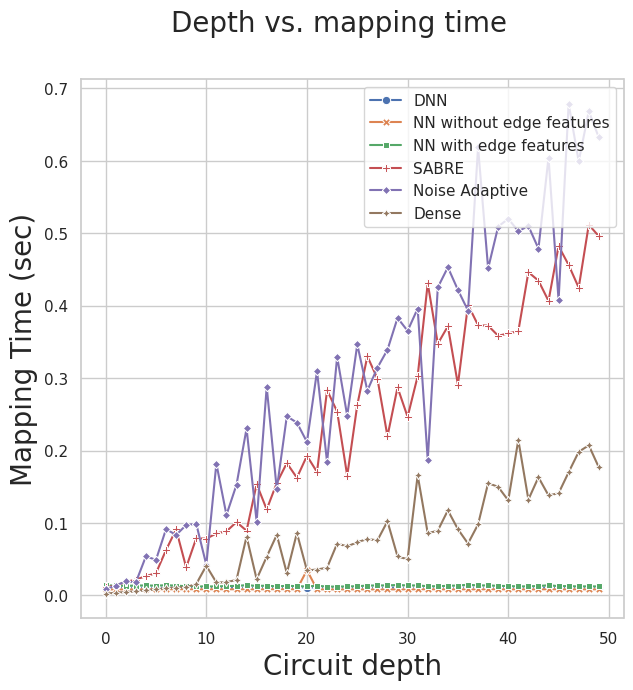

In [96]:
sns.set_theme(style="whitegrid")
a4_dims = (7,7)
fig, ax = plt.subplots(figsize=a4_dims)
sns.lineplot(data = df,markers=True, dashes=False)
fig.suptitle('Depth vs. mapping time ', fontsize=20)
plt.xlabel("Circuit depth", fontsize=20)
plt.ylabel("Mapping Time (sec)", fontsize=20)
plt.legend(loc='upper right')

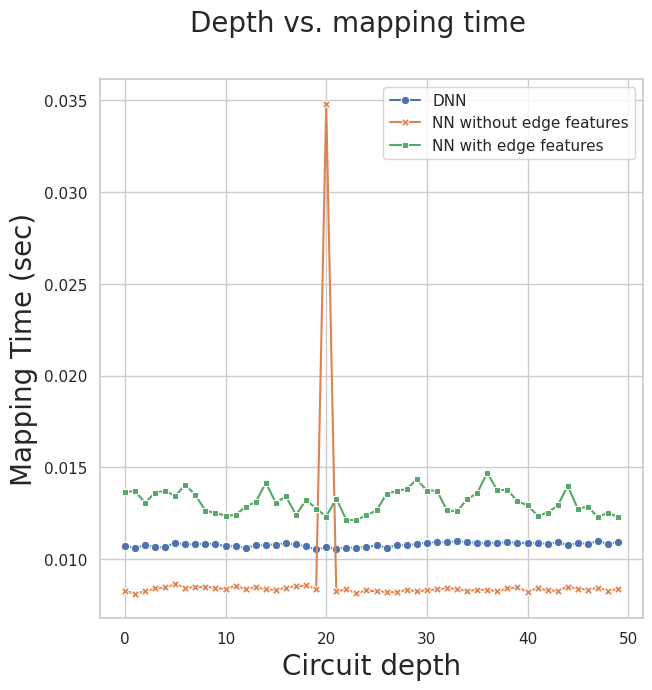

In [97]:
sns.set_theme(style="whitegrid")
a4_dims = (7,7)
fig, ax = plt.subplots(figsize=a4_dims)
sns.lineplot(data = df[["DNN","NN without edge features","NN with edge features"]],markers=True, dashes=False)
fig.suptitle('Depth vs. mapping time ', fontsize=20)
plt.xlabel("Circuit depth", fontsize=20)
plt.ylabel("Mapping Time (sec)", fontsize=20)
plt.legend(loc='upper right')

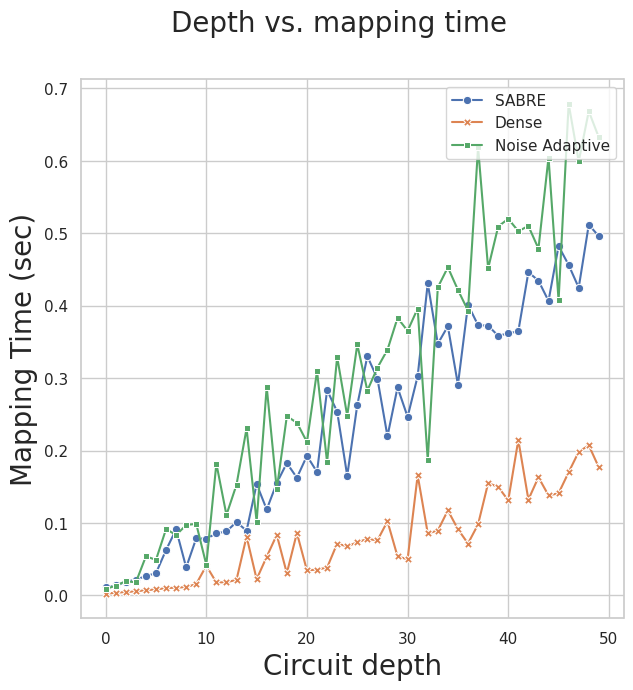

In [98]:
sns.set_theme(style="whitegrid")
a4_dims = (7,7)
fig, ax = plt.subplots(figsize=a4_dims)
sns.lineplot(data = df[["SABRE","Dense","Noise Adaptive"]],markers=True, dashes=False)
fig.suptitle('Depth vs. mapping time ', fontsize=20)
plt.xlabel("Circuit depth", fontsize=20)
plt.ylabel("Mapping Time (sec)", fontsize=20)
plt.legend(loc='upper right')